In [2]:
from netCDF4 import Dataset
import numpy as np
import os
from glob import glob
import datetime as dt
from netCDF4 import date2num,num2date
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr 

In [51]:
time_ref=dt.datetime(2023,2,21)
event_key=time_ref.strftime("%Y%m%d")
model_type = ['/normal/','/ashley/']
type_str = ['FAC-driven', 'Ashley']

model_choice = 0
height = 400

if model_choice == 0:
    type_m = type_str[0]
    model = model_type[0]
elif model_choice == 1:
    type_m = type_str[1]
    model = model_type[1]

print ("Working on:",event_key)

if height == 400:
    event_key = str(event_key)+'_400'

home_pt='/glade/work/prasoonv/gitm/code/2dall/'   
data_pt=home_pt+event_key+model+'output/2dall_final/'

print(data_pt)

save_pt=data_pt
if not os.path.exists(save_pt):                                            
    os.makedirs(save_pt)     

fname=data_pt+'combined_parms_2dall.npz'

data=np.load(fname)
for key in data.files:
    print(f"Key: {key}")
    print(f"Shape: {data[key].shape}")
    print(f"Data Type: {data[key].dtype}")
    print(f"Sample Data: {data[key][:5]}")  # Print the first 5 elements
    print("="*50)
dimensions=["ut","glon","glat"]

gitm_time_ref=time_ref + dt.timedelta(days=1)
ut=data['ut']
ut=[(dt.timedelta(hours=(i-ut[0])) + gitm_time_ref) for i in ut]

ds = xr.Dataset(
    coords={'ut':ut,
            'glon':data['glon'],
            'glat':data['glat']})
for key in data.files[3:]:
    ds[key]=(('ut','glon','glat'),data[key])    
print(ds)


Working on: 20230221
/glade/work/prasoonv/gitm/code/2dall/20230221_400/normal/output/2dall_final/
Key: ut
Shape: (433,)
Data Type: float64
Sample Data: [5.55555556e-04 1.67222222e-01 3.33333333e-01 5.00277778e-01
 6.66666667e-01]
Key: glon
Shape: (72,)
Data Type: float64
Sample Data: [ 2.5  7.5 12.5 17.5 22.5]
Key: glat
Shape: (72,)
Data Type: float64
Sample Data: [-88.75 -86.25 -83.75 -81.25 -78.75]
Key: pot
Shape: (433, 72, 72)
Data Type: float64
Sample Data: [[[-18864.18983392 -14017.26980501  -9296.97514194 ...   3227.75233921
     2986.62817054   4230.21762807]
  [-18888.1542991  -14029.81545166  -9111.69648829 ...   3886.07203837
     3415.29172662   4386.47949023]
  [-18930.31397572 -14110.58611947  -8986.76049801 ...   4499.38875843
     3845.69976723   4545.44238542]
  ...
  [-18890.68613776 -14350.37383687 -10106.97420916 ...   1042.61106743
     1726.81686189   3811.49996589]
  [-18865.59092931 -14202.38274238  -9815.09926378 ...   1805.8442689
     2139.86520894   3940.6556

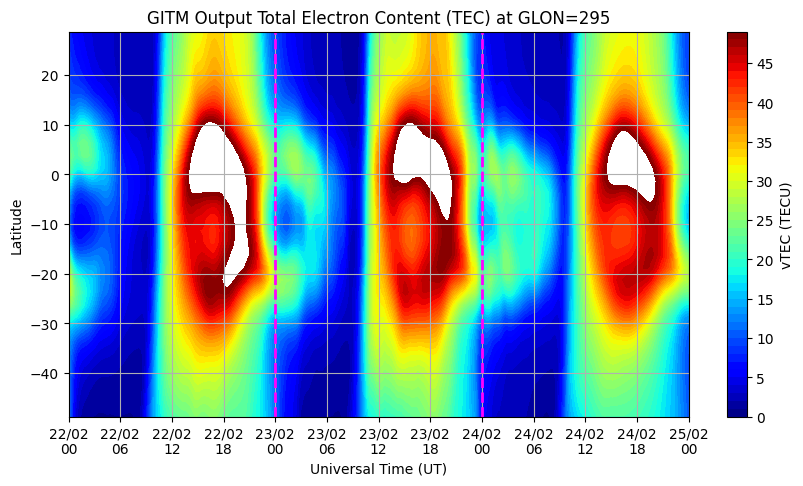

<Figure size 640x480 with 0 Axes>

In [52]:
glon_interest = -65
glon_SA = 360 + glon_interest
ds1 = ds.sel(glon=glon_SA, method='nearest')

time = ds1.ut.values
glat = ds1.glat.values
tec = ds1.tec.values
exb = ds1.ExB.values
wi = ds1.Wi.values

glat_min = -50
glat_max = 30
glat_mask = (glat >= glat_min) & (glat <= glat_max)
lat_filt = glat[glat_mask]
tec_filt = tec[:, glat_mask]
#exb_filt = exb[:, glat_mask]
#wi = wi[:, glat_mask]

X,Y=np.meshgrid(time,lat_filt)
Z=(tec_filt).T

# Create time meshgrid for contourf
#time_mesh, lat_mesh = np.meshgrid(time, lat_filt, indexing='ij')

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
levels = range(0, 50,1)  # Adjust levels as needed
#pcm = ax.contourf(time_mesh, lat_mesh, tec_filt, levels=levels, cmap="jet")
pcm = ax.contourf(X,Y,Z,cmap='jet',levels=levels)

xlim_start = dt.datetime.combine(gitm_time_ref, dt.time(0, 0, 0))
xlim_end = xlim_start + dt.timedelta(days=3)
ax.set_xlim(xlim_start, xlim_end)
ax.axvline(pd.Timestamp('2023-02-23 00:00:00'), color='magenta', linestyle='--', linewidth=2)
ax.axvline(pd.Timestamp('2023-02-24 00:00:00'), color='magenta', linestyle='--', linewidth=2)

# X-axis formatting: Set major ticks every 6 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H"))
ax.grid(True)

# Labels and title
plt.xlabel("Universal Time (UT)")
plt.ylabel("Latitude")
plt.title(f"GITM Output Total Electron Content (TEC) at GLON={glon_SA}")

# Colorbar
cbar = plt.colorbar(pcm, ax=ax, label="vTEC (TECU)")

# Show plot
plt.show()
plt.savefig(f'{save_pt}gitm_tec.jpg')

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
import os
import datetime as dt
import importlib as il

import itertools

In [54]:
path = '/glade/work/prasoonv/scratch/'
event = 'feb_22_24_2023'
file = path + f'full_{event}.csv'

df = pd.read_csv(file)
df = df[(df['GDLAT'] <= 21) & (df['GDLAT'] >= -40)].reset_index()

df['DT'] = pd.to_datetime(df['DT'])
df['LT_dt'] = pd.to_datetime(df['LT_dt'])
df = df.drop(columns = ['index','Unnamed: 0'])


if event == 'feb_22_24_2023':
    start_date = '2023-02-21'
    end_date = '2023-02-26'
elif event == 'may_9_11_2024':
    start_date = '2024-05-09'
    end_date = '2024-05-11'
#df = df[(df['MLT_dt'] >= start_date) & (df['MLT_dt'] <= end_date)]
#print(df)

# CHECK - IT SHOULD BE 4.3hr
time_dif = (df.DT[0] - df.LT_dt[0])/pd.Timedelta(hours=1)
time_dif = round(time_dif,2)
print(f'UT = LT + {time_dif}hr')

UT = LT + 4.93hr


/glade/derecho/scratch/prasoonv/tmp/ipykernel_98976/4010709743.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df1['DT_bin'] = df1['DT'].dt.floor('10T')
/glade/derecho/scratch/prasoonv/tmp/ipykernel_98976/4010709743.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1 = df1.groupby(['time_bin', 'GDLAT_bin']).mean(numeric_only=True).reset_index()


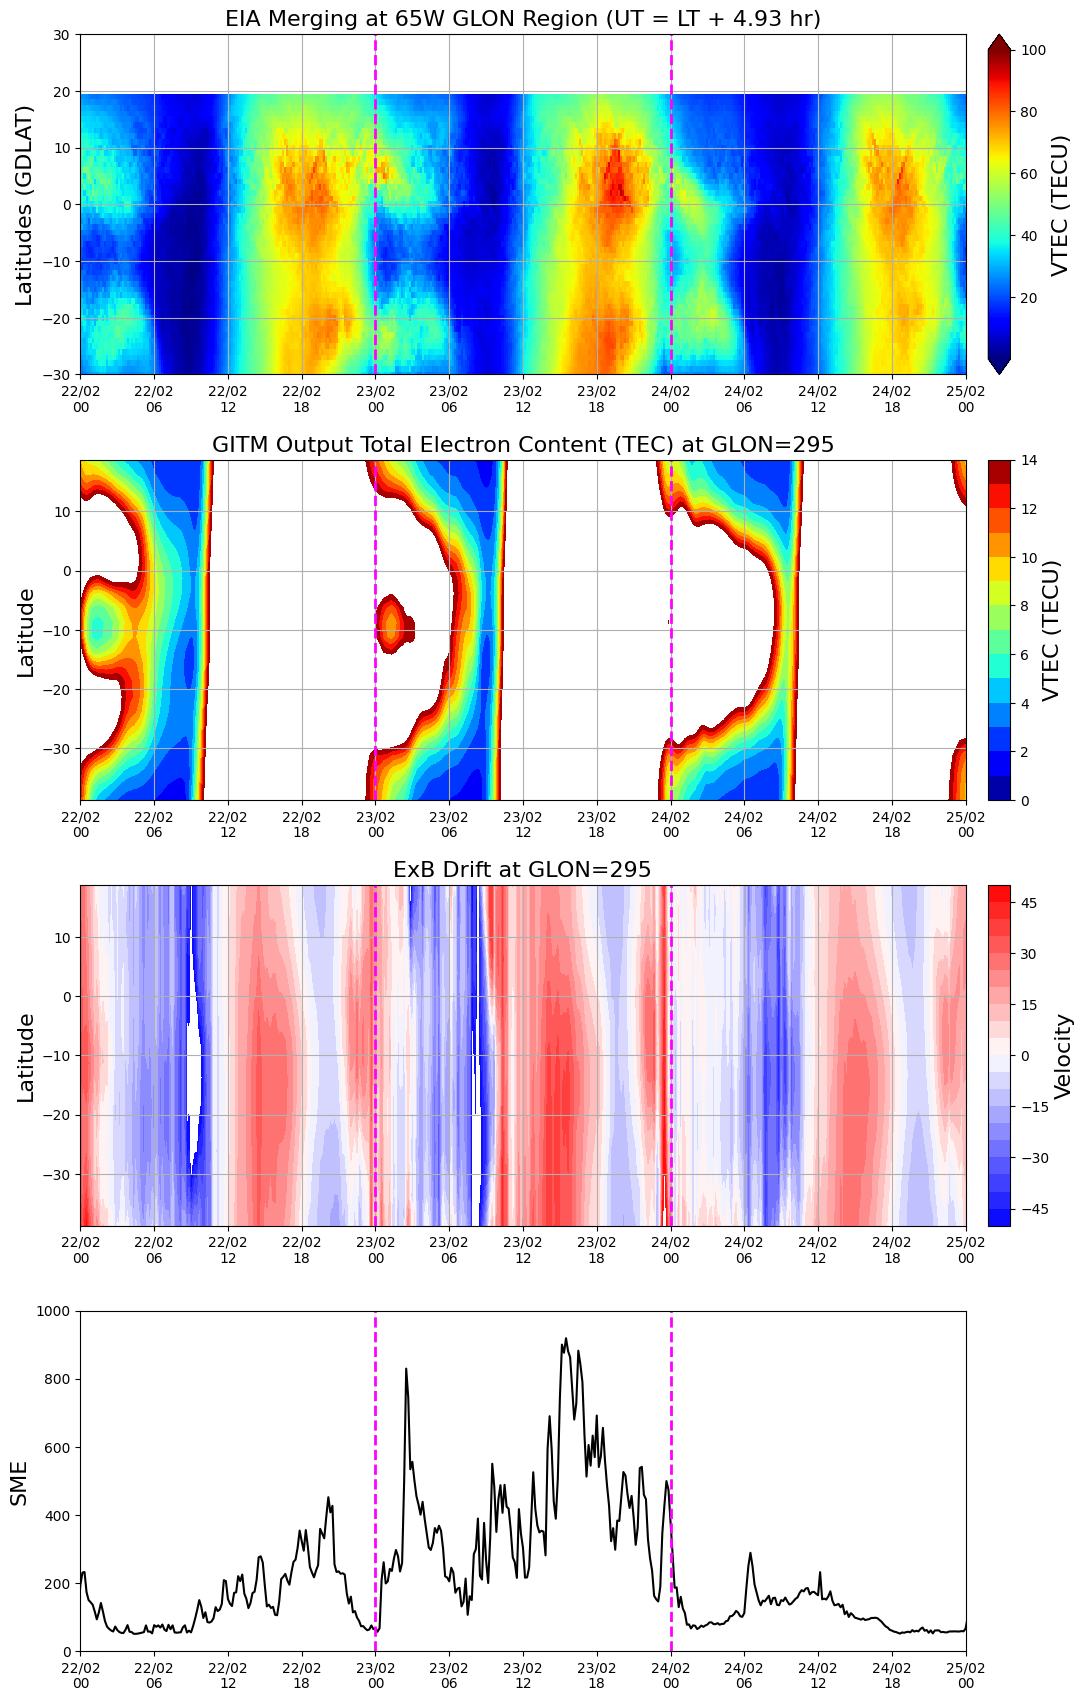

In [55]:
# Choice - Whether to plot across MLT or DT
time_types = ['LT_dt', 'DT']
t_coord = time_types[1]

# Define the MLAT bins from -30 to 30 with a step of 1
gdlat_bins = np.arange(-40,21,1)
df['GDLAT_bin'] = pd.cut(df['GDLAT'], bins=gdlat_bins, labels=gdlat_bins[:-1])

# Removing the Missing Data points of By and Bz
df.loc[(df['By'] == 999.9) & (df['Bz'] == 999.9), ['By', 'Bz']] = np.nan

df1 = df

if t_coord == 'MLT_dt':

    df1['MLT_dt_bin'] = df1['MLT_dt'].dt.floor('10T')
    df1 = df1.drop(columns = ['MLT', 'DT', 'MLAT', 'DOY'])
    df1.rename(columns={'MLT_dt': 'time'}, inplace=True)
    df1.rename(columns={'MLT_dt_bin': 'time_bin'}, inplace=True)

elif t_coord == 'DT':
    
    df1['DT_bin'] = df1['DT'].dt.floor('10T')
    df1 = df.drop(columns = ['LT', 'LT_dt', 'GDLAT', 'DOY'])
    df1.rename(columns={'DT': 'time'}, inplace=True)
    df1.rename(columns={'DT_bin': 'time_bin'}, inplace=True)

# Group by DT and MLAT_bin, then take the mean of other columns
df1 = df1.groupby(['time_bin', 'GDLAT_bin']).mean(numeric_only=True).reset_index()
df1['GDLAT_bin'] = df1['GDLAT_bin'].astype(int)
df1.rename(columns={'GDLAT_bin': 'GDLAT'}, inplace=True)
df1.rename(columns={'time_bin': 'time_dt'}, inplace=True)
#print(df1)
    
pivot_df = df1.pivot(index='GDLAT', columns='time_dt', values='TEC')
X,Y = np.meshgrid(pivot_df.columns.unique(), pivot_df.index.unique())
Z = pivot_df.values.reshape(X.shape)


fig = plt.figure(figsize=(12,21))
specs = fig.add_gridspec(4, 2, width_ratios = [1, 0.025], height_ratios=[1,1,1,1], hspace=0.25, wspace=0.05)

# First Plot - GNSS TEC
ax1 = fig.add_subplot(specs[0,0])
pcm = ax1.pcolormesh(X, Y, Z, shading='auto', vmax = 100, cmap='jet')
ax1.set_ylabel('Latitudes (GDLAT)', fontsize=16)
ax1.set_title(f'EIA Merging at 65W GLON Region (UT = LT + {time_dif} hr)', fontsize = 16)
ax1.set_ylim(-30,30)
ax1.grid(True)

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(pcm, cax = cbar_ax, label= 'VTEC (TECU)', extend='both')
cbar.set_label('VTEC (TECU)', fontsize = 16)

df2 = df1.drop(columns=['GDLAT'])
df2 = df2.groupby(['time_dt']).mean().reset_index()
xlim_start = dt.datetime.combine(gitm_time_ref, dt.time(0, 0, 0))
xlim_end = xlim_start + dt.timedelta(days=3)
ax1.set_xlim(xlim_start, xlim_end)


# Second Plot - GITM TEC
glat_min = -40
glat_max = 20
glat_mask = (glat >= glat_min) & (glat <= glat_max)
lat_filt = glat[glat_mask]
tec_filt = tec[:, glat_mask]

Xg,Yg=np.meshgrid(time,lat_filt)
Zg=(tec_filt).T

# Plot
ax2 = fig.add_subplot(specs[1,0])
levels = range(0,15,1)  # Adjust levels as needed
pcm = ax2.contourf(Xg,Yg,Zg,cmap='jet',levels=levels,vmax=levels[-1])
ax2.grid(True)

# Labels and title
#ax2.set_xlabel("Universal Time (UT)",fontsize=16)
ax2.set_ylabel("Latitude",fontsize=16)
ax2.set_title(f"GITM Output Total Electron Content (TEC) at GLON={glon_SA}",fontsize=16)

# Colorbar
cbar_ax = fig.add_subplot(specs[1,1])
cbar = fig.colorbar(pcm, cax = cbar_ax, label= 'VTEC (TECU)', extend='both')
cbar.set_label('VTEC (TECU)', fontsize = 16)


# Third plot - ExB Drift
exb_filt = exb[:, glat_mask]
Zgd = (exb_filt).T
#wi_filt = wi[:, glat_mask]
#Zgd = (wi_filt).T

# Plot
ax3 = fig.add_subplot(specs[2,0])
levels = range(-50,51,5)  # Adjust levels as needed
pcm = ax3.contourf(Xg,Yg,Zgd,cmap='bwr', levels=levels)
ax3.grid(True)
ax3.set_ylabel("Latitude",fontsize=16)
ax3.set_title(f"ExB Drift at GLON={glon_SA}",fontsize=16)

# Colorbar
cbar_ax = fig.add_subplot(specs[2,1])
cbar = fig.colorbar(pcm, cax = cbar_ax, label= 'Velocity', extend='both')
cbar.set_label('Velocity', fontsize = 16)


# Third plot - SME index
ax4 = fig.add_subplot(specs[3,0])
ax4.plot(df2.time_dt, df2.SME, color='black')
ax4.set_ylabel('SME', fontsize=16)
ax4.set_ylim(0,1000)


for ax in [ax1,ax2,ax3,ax4]:
    xlim_start = dt.datetime.combine(gitm_time_ref, dt.time(0, 0, 0))
    ax.set_xlim(xlim_start, xlim_end)
    ax.axvline(pd.Timestamp('2023-02-23 00:00:00'), color='magenta', linestyle='--', linewidth=2)
    ax.axvline(pd.Timestamp('2023-02-24 00:00:00'), color='magenta', linestyle='--', linewidth=2)
    
    # X-axis formatting: Set major ticks every 6 hours
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H"))
    
    
plt.savefig(f'{save_pt}gitm_tec_exb_sme.jpg', bbox_inches='tight', pad_inches=0)

#print(df2)


# vTEC, ExB and Meridional Wind Plots from GITM 

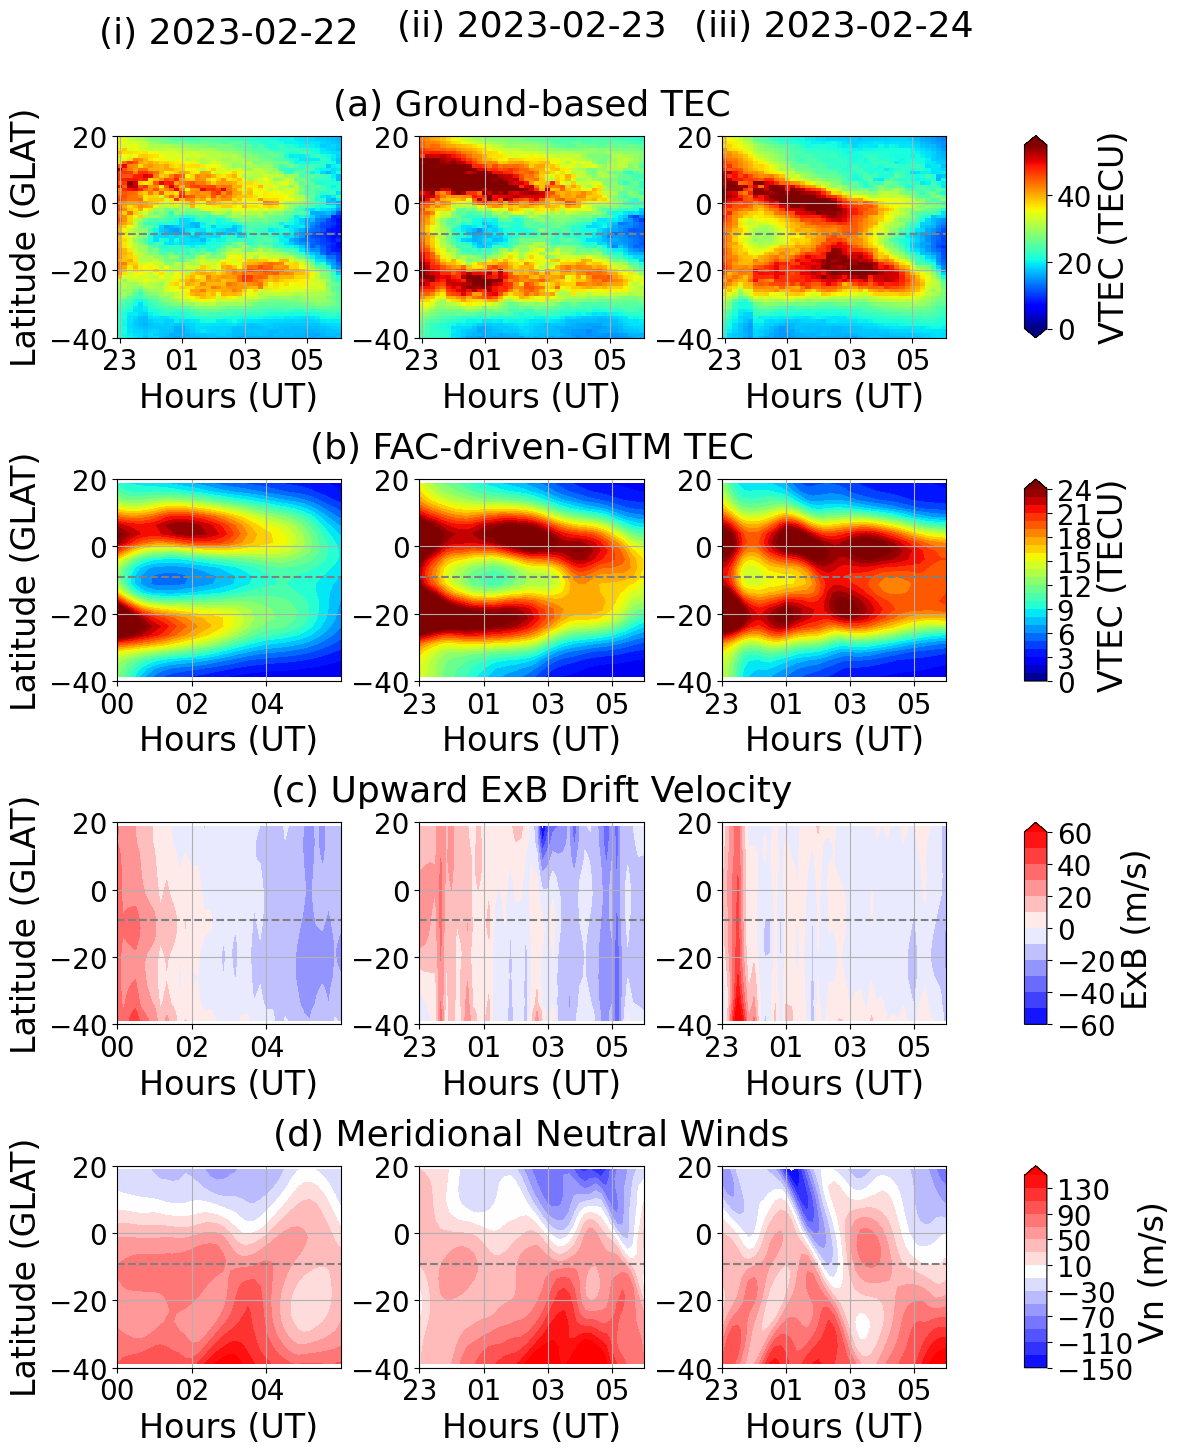

In [ ]:
fig=plt.figure(figsize=(12,16))
specs=fig.add_gridspec(4,4,width_ratios=[1,1,1,0.1],height_ratios=[1,1,1,1], wspace=0.45,hspace=0.7)

for i in range(3):
    date_s=gitm_time_ref+dt.timedelta(days=i-1)
    date_e=gitm_time_ref+dt.timedelta(days=i)
    time_s=dt.datetime.combine(date_s, dt.time(22, 55, 0))
    #time_s=dt.datetime.combine(date_s, dt.time(23, 59, 59))
    time_e=dt.datetime.combine(date_e, dt.time(6, 5, 0))
    #print(time_s, time_e)
    #print(date)
    
    # First Row - Madrigal TEC
    ax1=fig.add_subplot(specs[0,i])
    dft=df1[(df1.time_dt >= time_s) & (df1.time_dt <= time_e)]
    pivot_dft = dft.pivot(index='GDLAT', columns='time_dt', values='TEC')
    X,Y = np.meshgrid(pivot_dft.columns.unique(), pivot_dft.index.unique())
    Z = pivot_dft.values.reshape(X.shape)
    
    pcm1 = ax1.pcolormesh(X,Y,Z, shading='auto',vmax=55,vmin=0,cmap='jet')
    if i == 0:
        ax1.set_ylabel('Latitude (GLAT)',fontsize=24)
    ax1.set_xlabel('Hours (UT)',fontsize=24)
    ax1.set_ylim(-40,20)
    ax1.grid(True)
    if i == 0:
        ax1.set_title(f'(i) {str(date_e)[:-9]}\n\n',fontsize=26, pad=15)
    if i == 1:
        ax1.set_title(f'(ii) {str(date_e)[:-9]}\n\n(a) Ground-based TEC',fontsize=26, pad=15)
    if i == 2:
        ax1.set_title(f'(iii) {str(date_e)[:-9]}\n\n', fontsize=26, pad=15)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.axhline(y=-9.13, color='gray', linestyle='--')
    ax1.tick_params(labelsize=20)
    
    # Second Row - GITM TEC
    ax2=fig.add_subplot(specs[1,i])
    glat_min = -40
    glat_max = 20
    dst = ds1.where((ds1.glat>=glat_min) & (ds1.glat<=glat_max))
    dst=dst.sel(ut=slice(time_s, time_e))
    time_t = dst.ut.values
    tec_t = dst.tec.values
    glat_t = dst.glat.values
    
    Xg,Yg=np.meshgrid(time_t,glat_t)
    Zg=(tec_t).T
    if height == 400:
        levels = range(0,25,1)  # Adjust levels as needed
    else:
        levels = range(0,15,1)  # Adjust levels as needed
    pcm2 = ax2.contourf(Xg,Yg,Zg,cmap='jet',levels=levels,extend='max') 
    
    ax2.set_ylim(glat_min, glat_max)
    ax2.grid(True)
    ax2.set_xlabel('Hours (UT)',fontsize=24)
    if i == 0:
        ax2.set_ylabel("Latitude (GLAT)",fontsize=24)
    if i == 1:
        if type_m == 'Ashley':
            ax2.set_title(f'(b) GITM-{type_m} TEC',fontsize=26, pad=15)
        else:
            ax2.set_title(f'(b) {type_m}-GITM TEC',fontsize=26, pad=15)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax2.axhline(y=-9.13, color='gray', linestyle='--')
    ax2.tick_params(labelsize=20)
    
    
    # Third Row - ExB (upward velocity)
    ax3=fig.add_subplot(specs[2,i])
    exb_t = dst.ExB.values
        
    Zge=(exb_t).T
    levels = range(-60,61,10)  # Adjust levels as needed
    pcm3 = ax3.contourf(Xg,Yg,Zge,cmap='bwr',levels=levels,extend='max')

    ax3.set_ylim(glat_min, glat_max)
    ax3.grid(True)
    ax3.set_xlabel('Hours (UT)',fontsize=24)
    if i == 0:
        ax3.set_ylabel("Latitude (GLAT)",fontsize=24)
    if i == 1:
        ax3.set_title('(c) Upward ExB Drift Velocity',fontsize=26, pad=15)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax3.axhline(y=-9.13, color='gray', linestyle='--')
    ax3.tick_params(labelsize=20)
    
    '''
    # Third Row - SME
    ax4 = fig.add_subplot(specs[3,i])
    df3 = df2[(df2.time_dt >= time_s) & (df2.time_dt <= time_e)]
    ax4.plot(df3.time_dt, df3.SME, color='black')
    #print(df3)
    ax4.set_xlabel('Hours (UT)')
    ax4.set_ylabel('SME')
    ax4.set_ylim(0,1000)
    ax4.set_xlim(time_s, time_e)
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax4.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    '''
    

    # Fourth Row - Northward Velocity
    ax4=fig.add_subplot(specs[3,i])
    vn_t = dst.Vn.values
        
    Zgv=(vn_t).T
    levels = range(-150,155,20)  # Adjust levels as needed
    pcm4 = ax4.contourf(Xg,Yg,Zgv,cmap='bwr',levels=levels,extend='max')

    ax4.set_ylim(glat_min, glat_max)
    ax4.grid(True)
    ax4.set_xlabel('Hours (UT)',fontsize=24)
    if i == 0:
        ax4.set_ylabel("Latitude (GLAT)",fontsize=24)
    if i == 1:
        ax4.set_title('(d) Meridional Neutral Winds',fontsize=26, pad=15)
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax4.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax4.axhline(y=-9.13, color='gray', linestyle='--')
    ax4.tick_params(labelsize=20)
    
    
    if i == 2:
        # Third Column - Colorbars
        cbar_ax = fig.add_subplot(specs[0,3])
        cbar = fig.colorbar(pcm1,cax=cbar_ax,label='vTEC (TECU)', extend='both')
        cbar.set_label('VTEC (TECU)',fontsize=24)
        cbar.ax.tick_params(labelsize=20)
        
        cbar_ax = fig.add_subplot(specs[1,3])
        cbar = fig.colorbar(pcm2,cax=cbar_ax,label='vTEC (TECU)', extend='both')
        cbar.set_label('VTEC (TECU)',fontsize=24)
        cbar.ax.tick_params(labelsize=20)
        #ax.axhline(y=-9.13, color='black', linestyle='--')
        
        cbar_ax = fig.add_subplot(specs[2,3])
        cbar = fig.colorbar(pcm3,cax=cbar_ax,label='Units', extend='both')
        cbar.set_label('ExB (m/s)',fontsize=24)
        cbar.ax.tick_params(labelsize=20)
        
        cbar_ax = fig.add_subplot(specs[3,3])
        cbar = fig.colorbar(pcm4,cax=cbar_ax,label='Units', extend='both')
        cbar.set_label('Vn (m/s)',fontsize=24)
        cbar.ax.tick_params(labelsize=20)

plt.savefig(f'{save_pt}all_gitm_tec_exb_vn.jpg', bbox_inches='tight', pad_inches=0)
 
    


# GITM ExB Drift Plots

In [57]:
ds5 = ds


ds5 = ds5.sel(glat=-9.72, glon=(360-65), method='nearest')
print(ds5)

ds5['ExB_smooth'] = ds5['ExB'].rolling(ut=3, center=True).mean() # 30-min smoothening window
print(ds5)


<xarray.Dataset> Size: 35kB
Dimensions:  (ut: 433)
Coordinates:
  * ut       (ut) datetime64[ns] 3kB 2023-02-22 ... 2023-02-24T23:59:58
    glon     float64 8B 297.5
    glat     float64 8B -8.75
Data variables:
    pot      (ut) float64 3kB -4.1e+03 -3.347e+03 ... -1.512e+03 -1.548e+03
    tec      (ut) float64 3kB 12.54 10.79 9.206 7.799 ... 17.55 16.61 15.8 14.95
    int_jh   (ut) float64 3kB 2.937e-05 9.949e-05 ... 2.715e-05 2.878e-05
    eflux    (ut) float64 3kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ExB      (ut) float64 3kB 38.24 30.58 32.29 33.75 ... 12.94 16.81 16.26
    ON2      (ut) float64 3kB 0.5521 0.5535 0.5557 ... 0.5049 0.5049 0.5055
    Wi       (ut) float64 3kB -0.617 31.68 38.21 31.42 ... 12.99 15.96 15.91
    Rho      (ut) float64 3kB 4.018e-12 4.004e-12 4.011e-12 ... 3.042e-12 3e-12
    Vn       (ut) float64 3kB 68.27 71.13 73.89 75.71 ... 39.35 43.43 46.29
<xarray.Dataset> Size: 38kB
Dimensions:     (ut: 433)
Coordinates:
  * ut          (ut) dateti

289 289


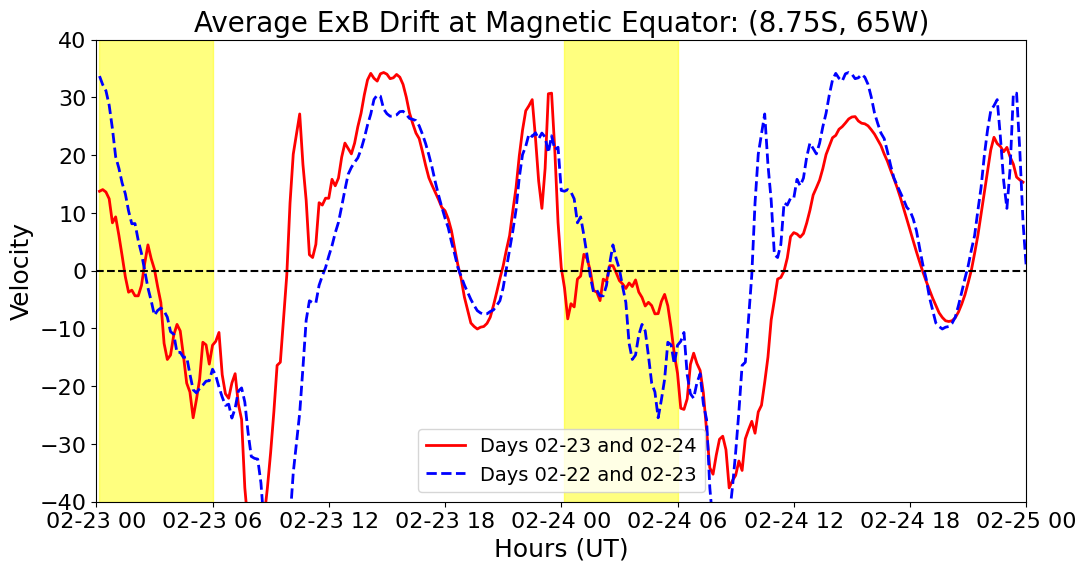

In [59]:
time_0 = pd.to_datetime('2023-02-22 00:00:00')
time_1 = pd.to_datetime('2023-02-23 00:00:00')
time_2 = pd.to_datetime('2023-02-24 00:00:00')
time_3 = pd.to_datetime('2023-02-25 00:00:00')


ds_a = ds5.sel(ut=slice(time_1, time_3))
ds_q = ds5.sel(ut=slice(time_0, time_2))
#time_q1 = ds_q.ut.values
#time_q2 = ds_q.ut.values
#time_q1 = [i+pd.Timedelta(days=1) for i in time_q1]
#time_q2 = [i+pd.Timedelta(days=2) for i in time_q2]
time_q = [i+pd.Timedelta(days=1) for i in ds_q.ut.values]
exb_q = list(ds_q.ExB_smooth.values)
print(len(time_q),len(exb_q))


fig = plt.figure(figsize=(12,6))
#specs = fig.add_gridspec(1,1, width_ratios=[1], height_ratios=[1])
#ax = ax.add_subplot(specs[0,0])
plt.plot(ds_a.ut, ds_a.ExB_smooth, label='Days 02-23 and 02-24',color='red',linewidth=2)
plt.plot(time_q, exb_q, label='Days 02-22 and 02-23',color='blue',linestyle='--',linewidth=2)
plt.legend(fontsize=14)
plt.ylim(-40,40)
plt.tick_params(labelsize=16)
# Below is 30-min moving average
plt.title('Average ExB Drift at Magnetic Equator: (8.75S, 65W)',fontsize=20)
plt.xlabel('Hours (UT)',fontsize=18)
plt.ylabel('Velocity',fontsize=18)
plt.fill_between(ds_a.ut, -40, 40, 
                 where=((ds_a.ut.values >= time_1) & (ds_a.ut.values <= pd.to_datetime('2023-02-23 06:00:00')) | (ds_a.ut.values >= time_2) & (ds_a.ut.values <= pd.to_datetime('2023-02-24 06:00:00'))),
                 color='yellow',
                 alpha=0.5
                 )
plt.axhline(y=0, color='black', linestyle='--')
#plt.axvline(x=pd.to_datetime('2023-02-24 00:00:00'),color='magenta', linestyle='--')
plt.xlim(time_1, time_3)

plt.savefig(f'{save_pt}gitm_exb.jpg')

# FPI and GITM Neutral Wind Plots

In [60]:
# obtain the csv files from code written in ganymede 
path_fpi = '/glade/work/prasoonv/sat-interp-tid-analysis/Qingyu_Cesar_EIA_IHA/EIAMerging/fabry_perot_data/'
file_fpi = [path_fpi + 'clf_total.csv', path_fpi + 'bfp_total.csv']


data_fpi = pd.read_csv(file_fpi[0])
data_fpi['DATETIME'] = pd.to_datetime(data_fpi['DATETIME'])
data_fpi = data_fpi.sort_values(by='DATETIME', ascending=True)
print(data_fpi)

     Unnamed: 0            DATETIME    VN1    VN2    DVN1    DVN2  VN1_SMOOTH  \
0           176 2023-02-22 23:05:00    NaN  50.37     NaN  0.3253     76.4400   
1           177 2023-02-22 23:07:00  76.44    NaN  0.5325     NaN     76.4400   
2           178 2023-02-22 23:10:00    NaN  46.39     NaN  0.3004     76.4400   
3           179 2023-02-22 23:35:00    NaN  16.67     NaN  0.1190     29.5675   
4           180 2023-02-22 23:37:00  33.17    NaN  0.2299     NaN     29.5675   
..          ...                 ...    ...    ...     ...     ...         ...   
344         171 2023-02-24 09:47:00    NaN   4.72     NaN  0.0397    -37.6350   
345         172 2023-02-24 09:49:00 -41.74    NaN  0.3485     NaN    -37.6350   
346         173 2023-02-24 09:52:00    NaN  10.80     NaN  0.1191    -37.6350   
347         174 2023-02-24 09:54:00 -39.48    NaN  0.3240     NaN    -37.6350   
348         175 2023-02-24 10:04:00    NaN  17.78     NaN  0.1497    -40.6100   

     VN2_SMOOTH  
0       4

<xarray.Dataset> Size: 35kB
Dimensions:  (ut: 433)
Coordinates:
  * ut       (ut) datetime64[ns] 3kB 2023-02-22 ... 2023-02-24T23:59:58
    glon     float64 8B 292.5
    glat     float64 8B 18.75
Data variables:
    pot      (ut) float64 3kB -2.762e+03 -1.928e+03 -3.225e+03 ... 574.4 524.8
    tec      (ut) float64 3kB 10.1 9.391 8.822 8.445 ... 11.9 11.22 10.61 10.07
    int_jh   (ut) float64 3kB 4.159e-05 4.004e-05 ... 4.249e-05 4.281e-05
    eflux    (ut) float64 3kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ExB      (ut) float64 3kB 38.13 31.97 34.47 33.6 ... 9.033 6.996 14.46 16.27
    ON2      (ut) float64 3kB 0.6711 0.671 0.6718 ... 0.6372 0.6361 0.6357
    Wi       (ut) float64 3kB 4.172 32.7 33.63 20.39 ... 7.64 6.107 13.31 15.63
    Rho      (ut) float64 3kB 4.29e-12 4.255e-12 ... 3.293e-12 3.23e-12
    Vn       (ut) float64 3kB -8.694 -11.71 -12.14 ... 3.16 -0.6827 -4.137
<xarray.Dataset> Size: 35kB
Dimensions:  (ut: 433)
Coordinates:
  * ut       (ut) datetime64[n

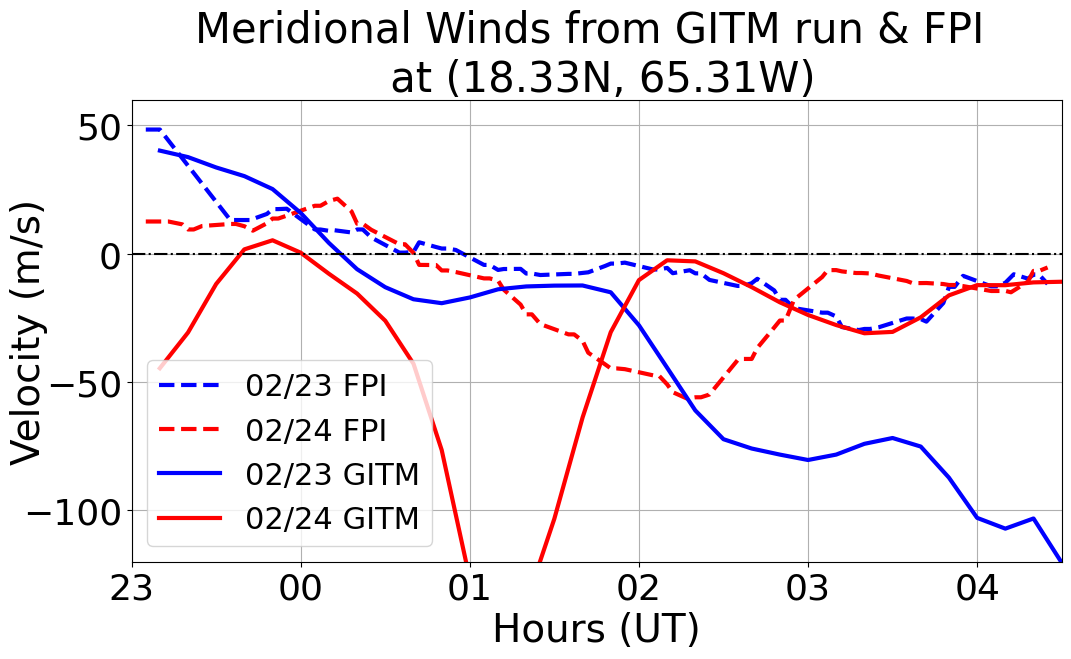

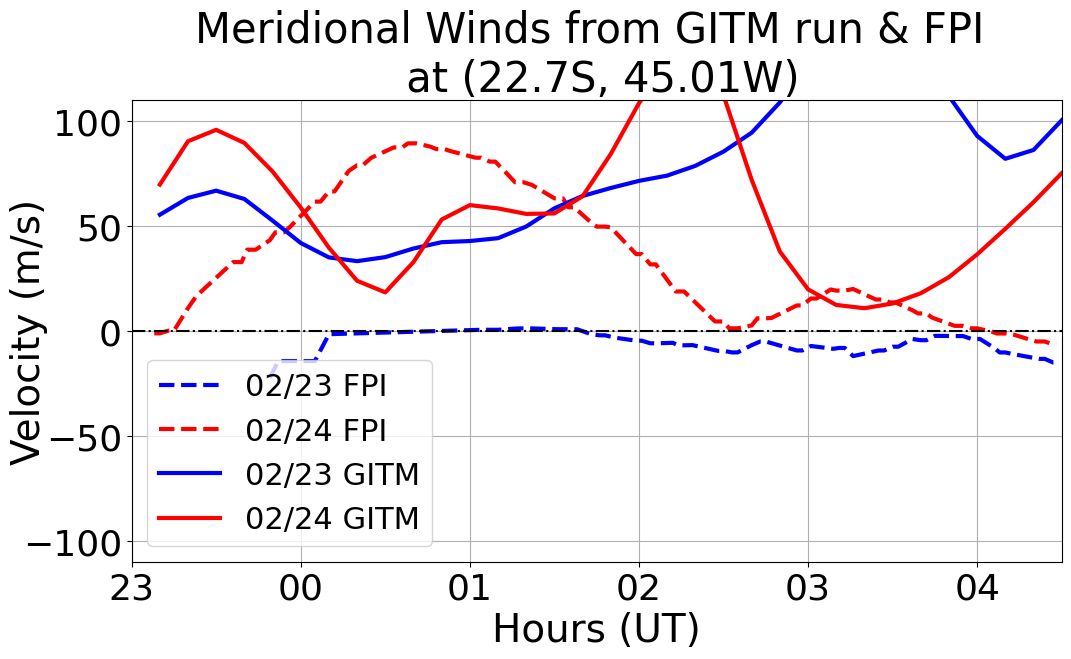

In [61]:
# Verification of Netrual Wind Data

glat = [18.33, -22.7]
glon = [294.69, 314.99]
coords_str = ['(18.33N, 65.31W)', '(22.7S, 45.01W)']
station_name = ['clf', 'bfp']

for lat, lon, sn, c, f in zip(glat, glon, station_name, coords_str, file_fpi):   
    
    # GITM data
    ds6 = ds
    ds6 = ds6.sel(glat=lat, glon=lon, method='nearest')
    print(ds6)


    time_00 = pd.to_datetime('2023-02-22 00:00:00')
    time_01 = pd.to_datetime('2023-02-22 04:30:00')
    time_10 = pd.to_datetime('2023-02-22 23:00:00')
    time_11 = pd.to_datetime('2023-02-23 04:30:00')
    time_20 = pd.to_datetime('2023-02-23 23:00:00')
    time_21 = pd.to_datetime('2023-02-24 04:30:00')

    ds6_00 = ds6.sel(ut=slice(time_00, time_01))
    time_0 = [i + pd.Timedelta(days=2) for i in ds6_00.ut.values]
    ds6_10 = ds6.sel(ut=slice(time_10, time_11))
    time_1 = [i + pd.Timedelta(days=1) for i in ds6_10.ut.values]
    ds6_20 = ds6.sel(ut=slice(time_20, time_21))

    # FPI data
    df_fpi = pd.read_csv(f)
    df_fpi['DATETIME'] = pd.to_datetime(df_fpi['DATETIME'])
    df_00 = df_fpi[(df_fpi['DATETIME'] >= time_00) &
                   (df_fpi['DATETIME'] <= time_01)]
    time_0f = [i + pd.Timedelta(days=2) for i in df_00['DATETIME']]
    df_10 = df_fpi[(df_fpi['DATETIME'] >= time_10) &
                   (df_fpi['DATETIME'] <= time_11)]
    time_1f = [i + pd.Timedelta(days=1) for i in df_10['DATETIME']]
    df_20 = df_fpi[(df_fpi['DATETIME'] >= time_20) &
                   (df_fpi['DATETIME'] <= time_21)]


    fig, ax = plt.subplots(figsize=(12,6))
    #ax.plot(time_0f, df_00.VN2_SMOOTH, label='02/22 FPI', color='green', linestyle='--', linewidth=2)
    ax.plot(time_1f, df_10.VN2_SMOOTH, label='02/23 FPI', color='blue', linestyle='--', linewidth=3)
    ax.plot(df_20.DATETIME, df_20.VN2_SMOOTH, label='02/24 FPI', color='red', linestyle='--', linewidth=3)
    
    #ax.plot(time_0, ds6_00.Vn, label='02/22 GITM', color='green',linewidth=2)
    ax.plot(time_1, ds6_10.Vn, label='02/23 GITM', color='blue',linewidth=3)
    ax.plot(ds6_20.ut, ds6_20.Vn, label='02/24 GITM', color='red',linewidth=3)
    
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_xlim(time_20, time_21)
    ax.legend(loc='lower left', fontsize=22)
    ax.grid(True)
    ax.set_title(f'Meridional Winds from GITM run & FPI \n at {c}',fontsize=30)
    ax.set_xlabel('Hours (UT)',fontsize=28)
    ax.set_ylabel('Velocity (m/s)',fontsize=28, labelpad=0)
    ax.yaxis.set_label_coords(-0.09, 0.5)
    ax.axhline(y=0, color='black', linestyle='-.')
    ax.tick_params(labelsize=26)
    
    if sn == 'clf':
        ax.set_ylim(-120, 60)
        
    elif sn == 'bfp':
        ax.set_ylim(-110, 110)
    
    plt.plot()
    plt.savefig(f'{save_pt}gitm_{sn}_vn.jpg')

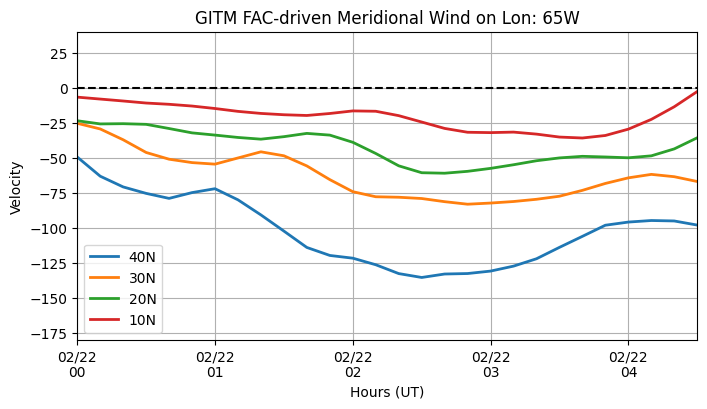

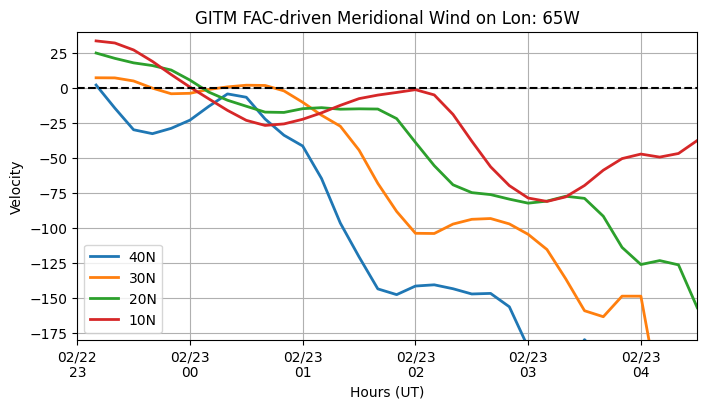

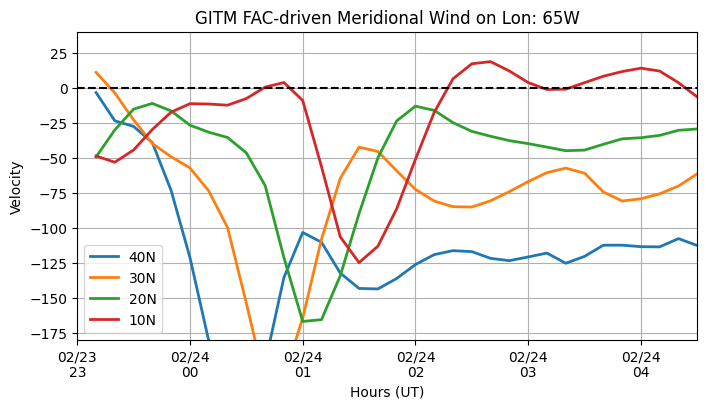

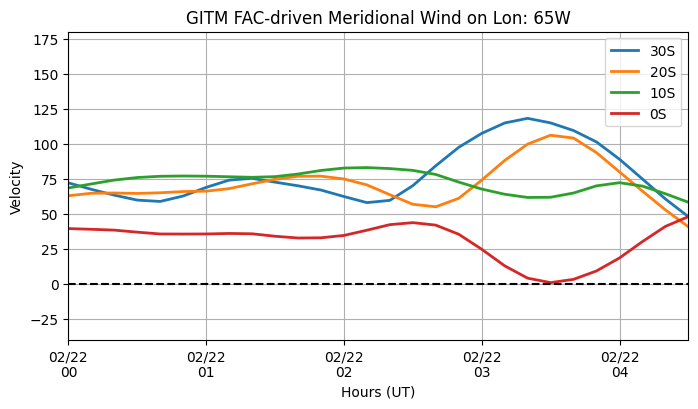

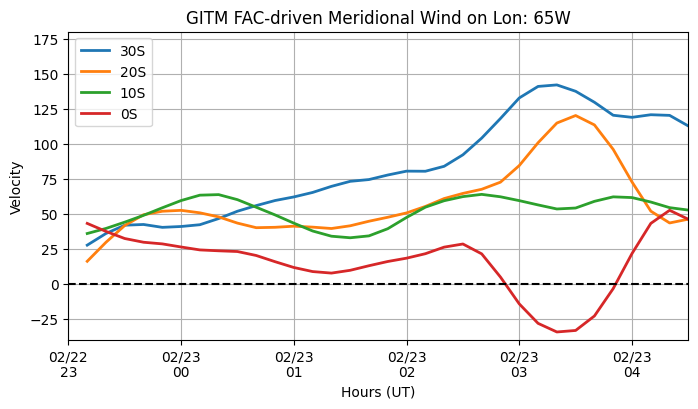

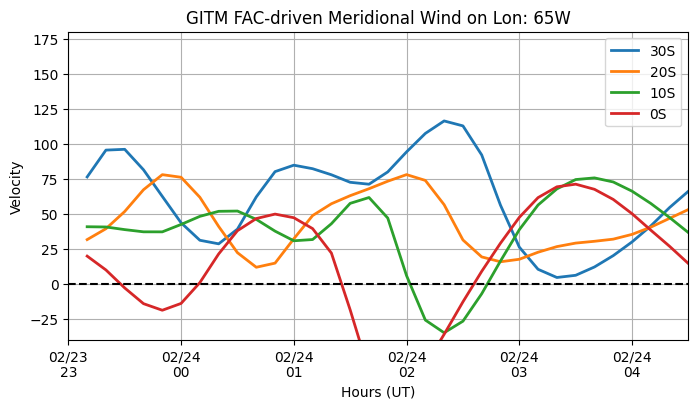

In [63]:
# Plotting Every day's Vn Meridional Winds at different lat in same plot

glon = 360 - 65
glat_n = list(range(40, 9, -10))
glat_s = list(range(-30, 1, 10))
glats = [glat_n, glat_s]
region = ['N', 'S']


for glat_t, r in zip(glats, region):
 
    time_s = [time_00, time_10, time_20]   
    time_e = [time_01, time_11, time_21]
    for t_s, t_e in zip(time_s, time_e):
        
        fig, ax = plt.subplots(figsize=(8,4))       
        for lat in glat_t:
            # GITM data
            ds7 = ds
            ds7 = ds7.sel(glat=lat, glon=glon, method='nearest')
            ds7 = ds7.sel(ut=slice(t_s, t_e))
            
            ax.plot(ds7.ut, ds7.Vn, label=f'{abs(lat)}{r}',linewidth=2)
    
        ax.set_title(f'GITM {type_m} Meridional Wind on Lon: 65W')
        if r == 'N':
            ax.set_ylim(-180,40)
        elif r == 'S':
            ax.set_ylim(-40,180)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.legend()
        ax.set_xlabel('Hours (UT)')
        ax.set_ylabel('Velocity')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.set_xlim(t_s, t_e)
        ax.grid(True)
        fig.show()
    
    

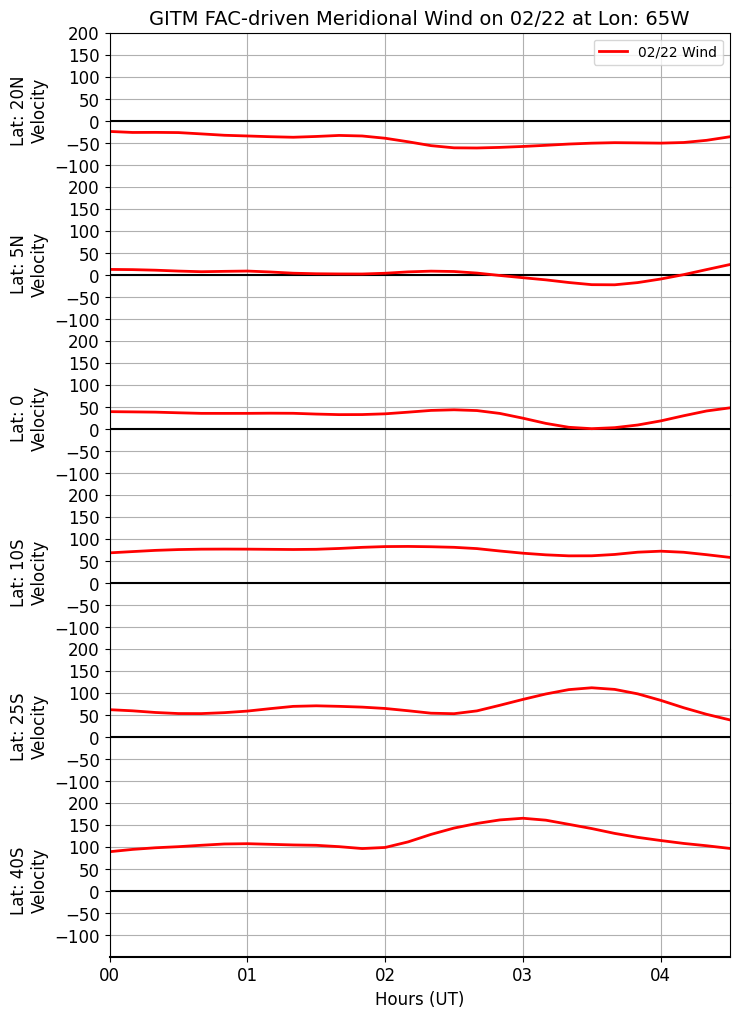

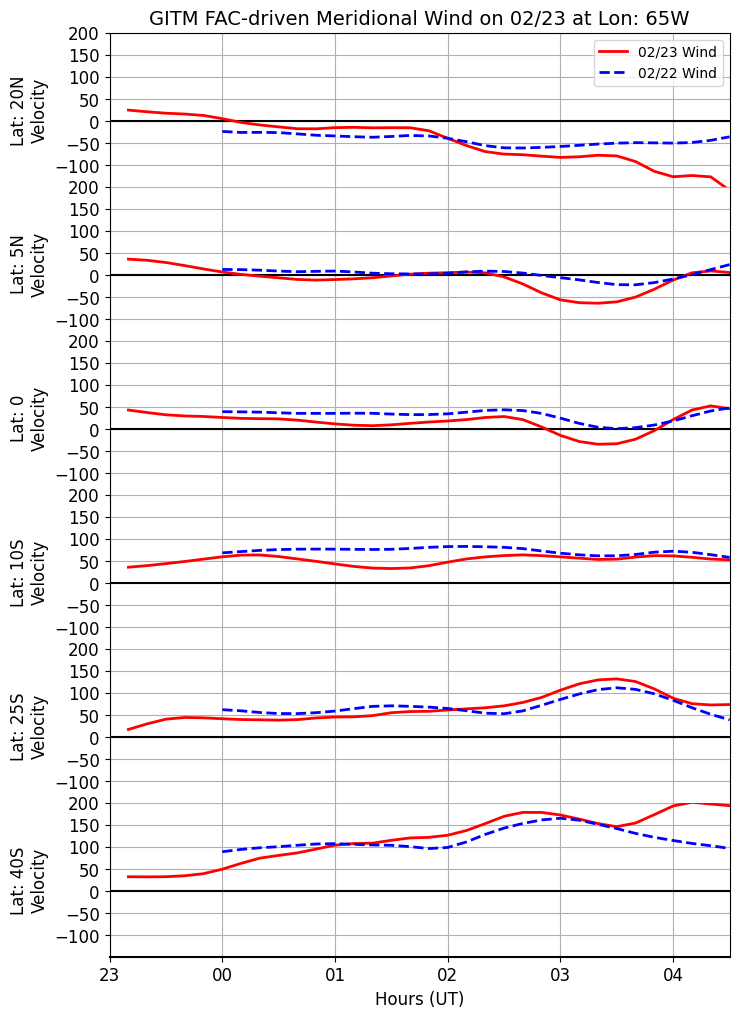

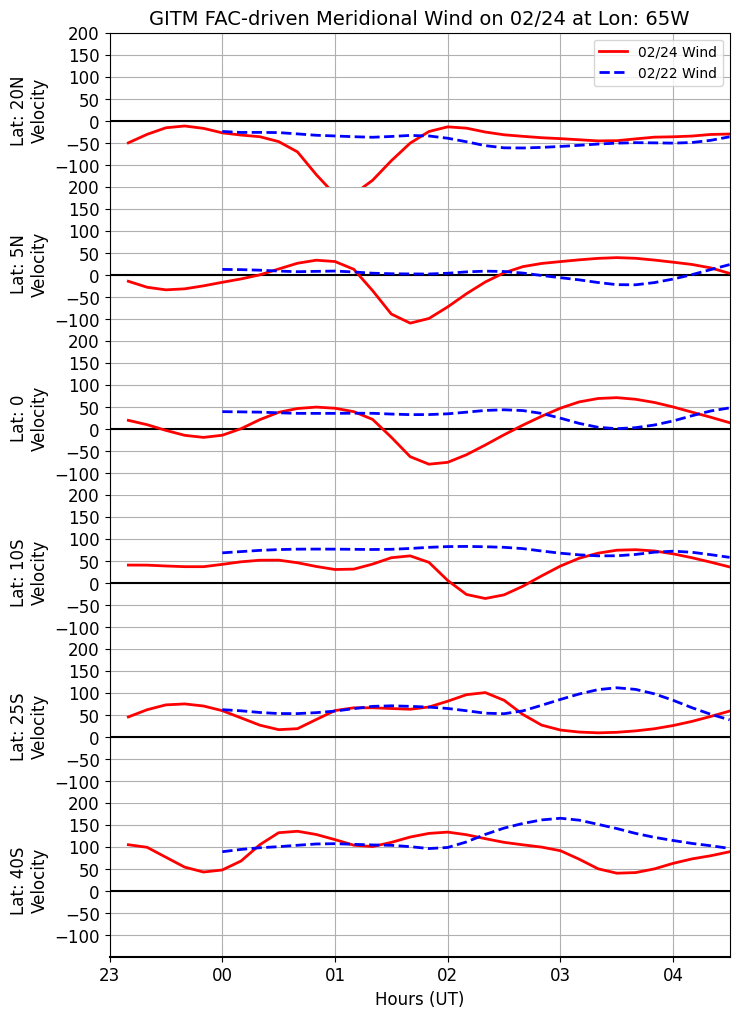

In [64]:
# Plots for paper

# Plotting Every day's Vn Meridional Winds at different lat in same plot

glon = 360 - 65
hemis = ['N', 'N', '', 'S', 'S', 'S']
glat = [20, 5, 0, -10, -25, -40]
dates = ['02/22', '02/23', '02/24']


time_s = [time_00, time_10, time_20]   
time_e = [time_01, time_11, time_21]
for j, (t_s, t_e, d) in enumerate(zip(time_s, time_e, dates)):
    

    
    fig, axes = plt.subplots(nrows=6, sharex=True, sharey=True, figsize=(8, 12))       
    for i, (ax, lat, h) in enumerate(zip(axes, glat, hemis)):
        # GITM data
        ds7 = ds
        ds7 = ds7.sel(glat=lat, glon=glon, method='nearest')        
        ds7 = ds7.sel(ut=slice(t_s, t_e))
        ds_22 = ds.sel(ut=slice(time_00,time_01))
        ds_22 = ds_22.sel(glat=lat, glon=glon, method='nearest')
        time_22 = [k + pd.Timedelta(days=j) for k in ds_22.ut.values]
        
        
        #print(ds7.ut.values)
        ax.axhline(y=0, color='black')
        ax.plot(ds7.ut, ds7.Vn,linewidth=2, color='red', label=f'{d} Wind')
            
        if d != '02/22':
            ax.plot(time_22, ds_22.Vn,linewidth=2, color='blue', label=f'02/22 Wind', linestyle='--')
        
        #ax.legend()
        ax.set_xlim(t_s, t_e)
        ax.set_ylim(-149,200)
        if i == 0:
            ax.legend()
        
        ax.set_xlabel('Hours (UT)', fontsize=12)
        ax.set_ylabel(f'Lat: {str(abs(lat))}{h}\nVelocity', fontsize=12)
        ax.grid(True)
        
        # Keep a solid line to separate each subplot (bottom spine)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_linewidth(1.5)
        
        ax.tick_params(axis='y', labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    
        
        
    axes[0].set_title(f'GITM {type_m} Meridional Wind on {d} at Lon: 65W', fontsize=14)
    
    # Hide x-ticks for all but the last plot
    #if i != len(axes) - 1:
    #    ax.set_xticks([])

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
    axes[-1].tick_params(axis='x', labelsize=12)
    axes[-1].spines['bottom'].set_visible(True)
    axes[0].spines['top'].set_visible(True)
    #axes[-1].set_xticks(np.arange(0, 6, 1))  # Show x-ticks only on last plot
    axes[-1].set_xlabel("Hours (UT)")
    plt.subplots_adjust(hspace=0)  
    fig.show()
   


In [65]:
print(ds)

<xarray.Dataset> Size: 162MB
Dimensions:  (ut: 433, glon: 72, glat: 72)
Coordinates:
  * ut       (ut) datetime64[ns] 3kB 2023-02-22 ... 2023-02-24T23:59:58
  * glon     (glon) float64 576B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * glat     (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables:
    pot      (ut, glon, glat) float64 18MB -1.886e+04 -1.402e+04 ... -103.3
    tec      (ut, glon, glat) float64 18MB 13.77 13.73 13.41 ... 2.218 3.505
    int_jh   (ut, glon, glat) float64 18MB 6.246e-05 8.08e-05 ... 1.558e-05
    eflux    (ut, glon, glat) float64 18MB 0.09431 0.1586 ... 0.02976 0.04101
    ExB      (ut, glon, glat) float64 18MB -42.36 -65.72 -80.8 ... 1.24 0.7951
    ON2      (ut, glon, glat) float64 18MB 0.3514 0.3704 0.3879 ... 0.591 0.564
    Wi       (ut, glon, glat) float64 18MB 39.45 27.12 20.56 ... -35.92 -40.01
    Rho      (ut, glon, glat) float64 18MB 5.434e-12 5.255e-12 ... 3.006e-12
    Vn       (ut, glon, glat) float64 18MB 138.9 1

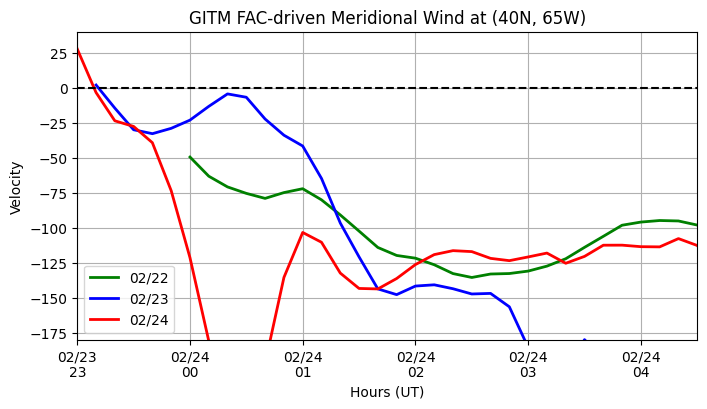

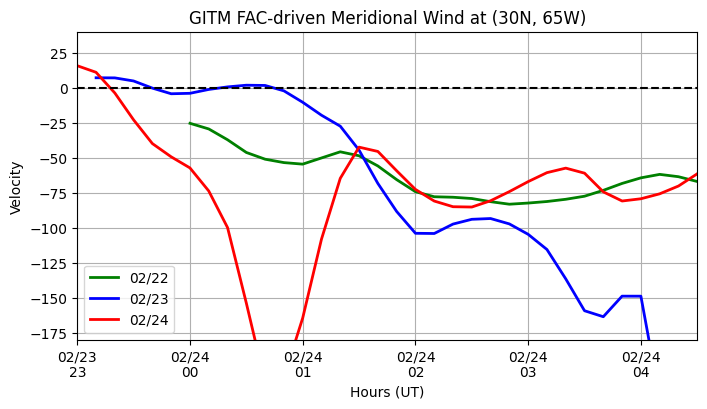

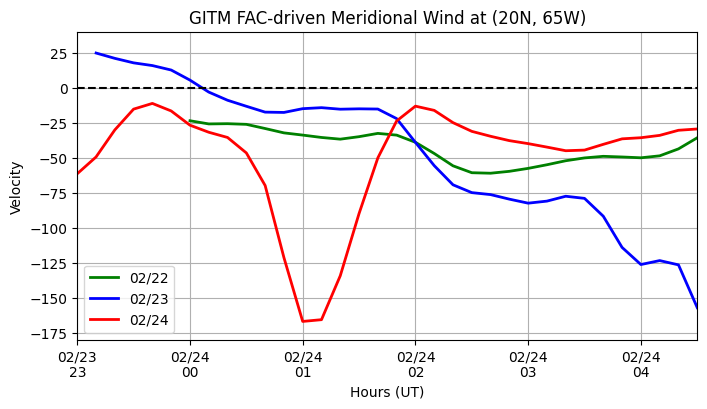

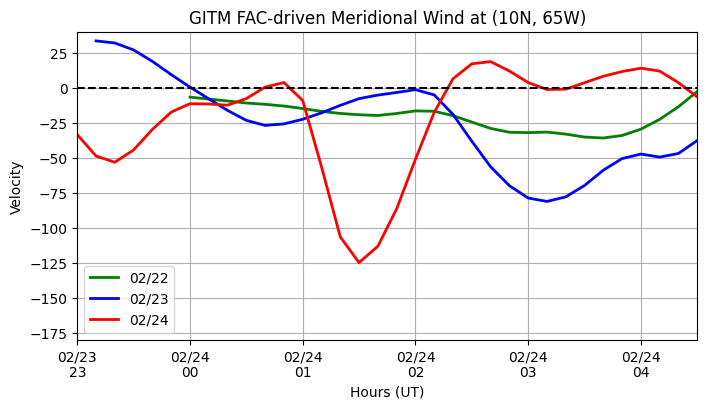

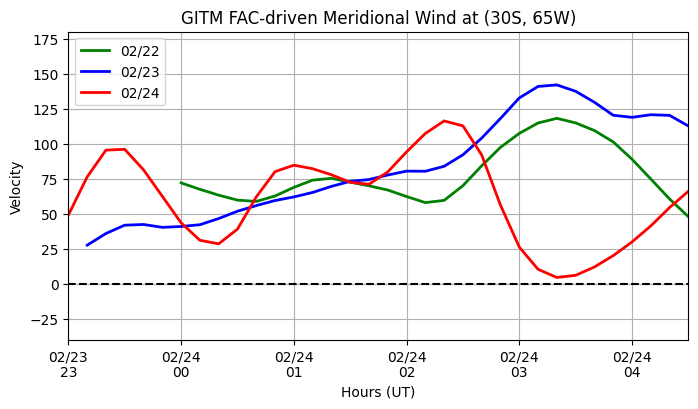

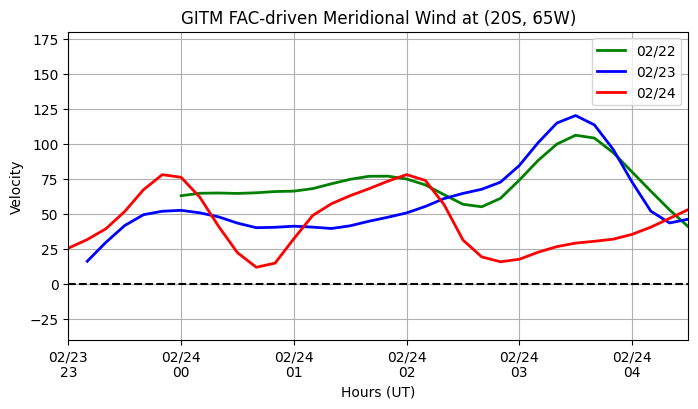

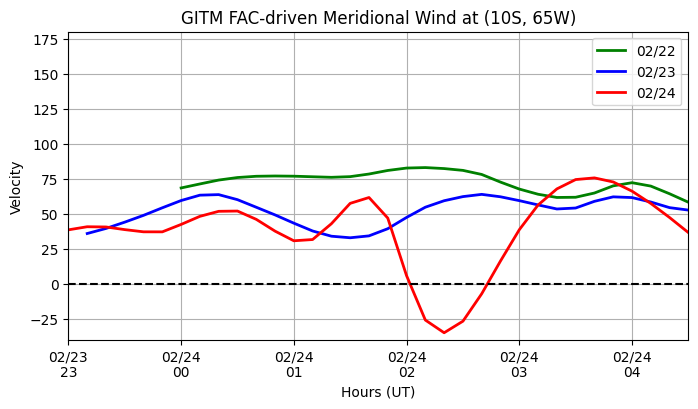

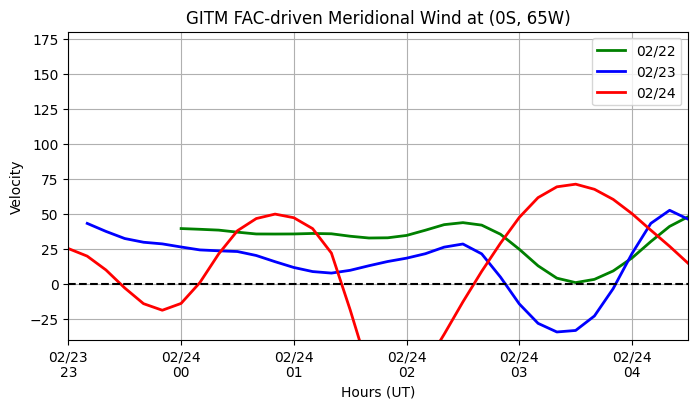

In [66]:
# Plotting Each day's Meridional Wind at single lat

glon = 360 - 65
glat_n = list(range(40, 9, -10))
glat_s = list(range(-30, 1, 10))
glats = [glat_n, glat_s]
region = ['N', 'S']


for glat_t, r in zip(glats, region):
    
    
    for lat in glat_t:
        # GITM data
        ds8 = ds
        ds8 = ds8.sel(glat=lat, glon=glon, method='nearest')
        ds8_22 = ds8.sel(ut=slice(time_00, time_01))
        t8_22 = [i + pd.Timedelta(days=2) for i in ds8_22['ut'].values]
        #t8_22 = pd.to_datetime(t8_22)
        ds8_23 = ds8.sel(ut=slice(time_10, time_11))
        t8_23 = [i + pd.Timedelta(days=1) for i in ds8_23['ut'].values]
        #t8_23 = pd.to_datetime(t8_23)
        ds8_24 = ds8.sel(ut=slice(time_20, time_21))
        
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(t8_22, ds8_22.Vn, label='02/22',linewidth=2, color='green')
        ax.plot(t8_23, ds8_23.Vn, label='02/23',linewidth=2, color='blue')
        ax.plot(ds8.ut, ds8.Vn, label='02/24',linewidth=2, color='red')
        
   
        ax.set_title(f'GITM {type_m} Meridional Wind at ({abs(lat)}{r}, 65W)')
        
        ax.axhline(y=0, color='black', linestyle='--')
        ax.legend()
        ax.set_xlabel('Hours (UT)')
        ax.set_ylabel('Velocity')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.set_xlim(time_20, time_21)
        if r == 'N':
            ax.set_ylim(-180,40)
        elif r == 'S':
            ax.set_ylim(-40,180)
        ax.grid(True)
        fig.show()
        

# Polar Plots of Integrated Joule Heating and Neutral Winds

In [67]:


ds['Vn_avg'] = ds['Vn'].rolling(ut=3, center=True).mean()
ds['Vn_diff'] = ds['Vn']-ds['Vn_avg']
ds['tec_avg'] = ds['tec'].rolling(ut=3, center=True).mean()
ds['tec_diff'] = ds['tec']-ds['tec_avg']

print(ds)

<xarray.Dataset> Size: 233MB
Dimensions:   (ut: 433, glon: 72, glat: 72)
Coordinates:
  * ut        (ut) datetime64[ns] 3kB 2023-02-22 ... 2023-02-24T23:59:58
  * glon      (glon) float64 576B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * glat      (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables: (12/13)
    pot       (ut, glon, glat) float64 18MB -1.886e+04 -1.402e+04 ... -103.3
    tec       (ut, glon, glat) float64 18MB 13.77 13.73 13.41 ... 2.218 3.505
    int_jh    (ut, glon, glat) float64 18MB 6.246e-05 8.08e-05 ... 1.558e-05
    eflux     (ut, glon, glat) float64 18MB 0.09431 0.1586 ... 0.02976 0.04101
    ExB       (ut, glon, glat) float64 18MB -42.36 -65.72 -80.8 ... 1.24 0.7951
    ON2       (ut, glon, glat) float64 18MB 0.3514 0.3704 0.3879 ... 0.591 0.564
    ...        ...
    Rho       (ut, glon, glat) float64 18MB 5.434e-12 5.255e-12 ... 3.006e-12
    Vn        (ut, glon, glat) float64 18MB 138.9 125.2 102.5 ... -279.1 -279.8
    Vn_avg 

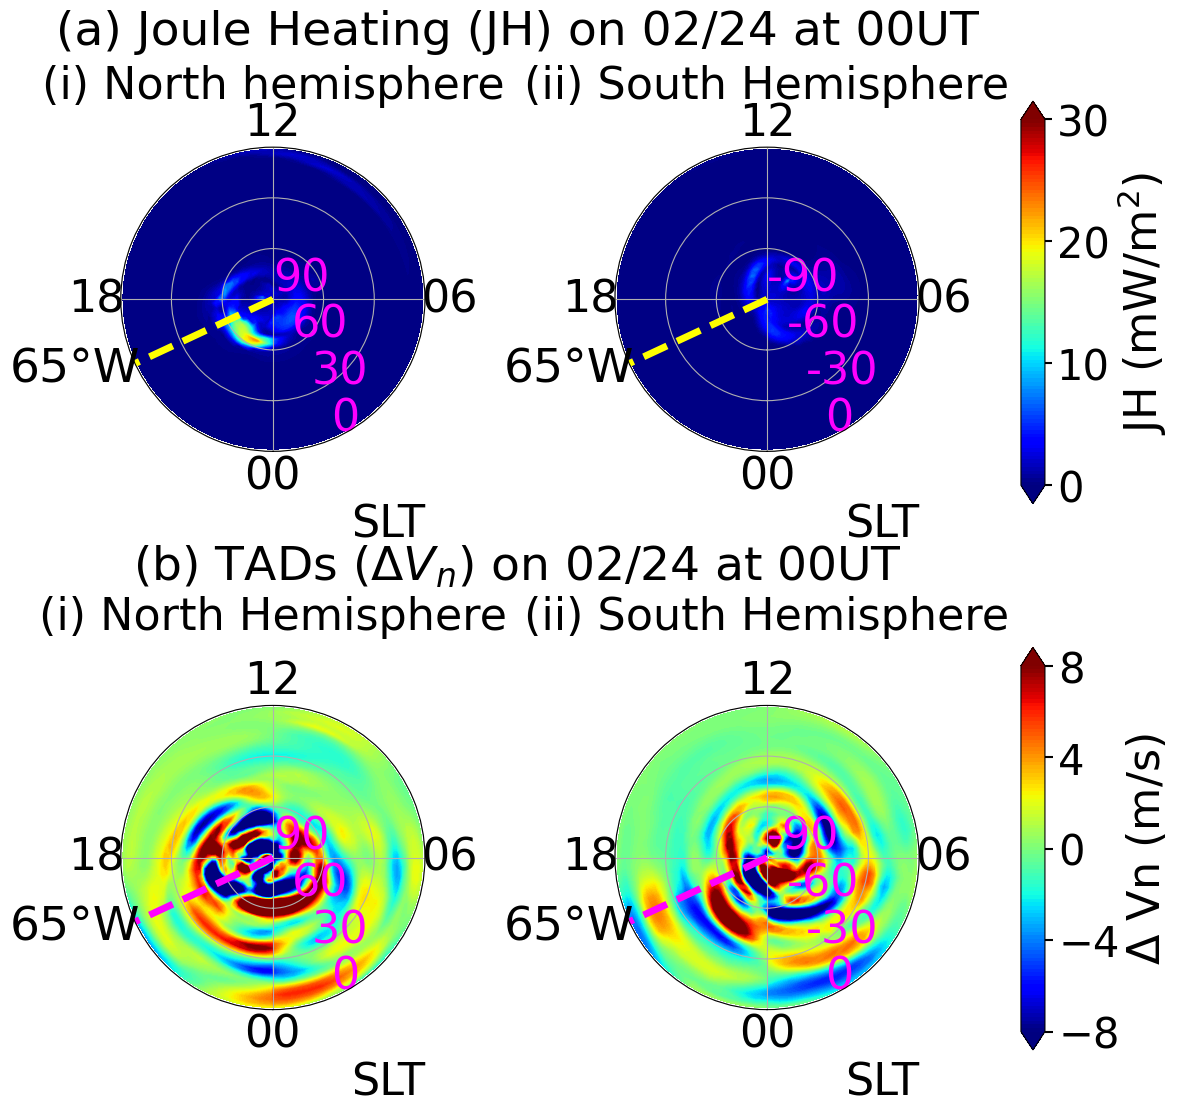

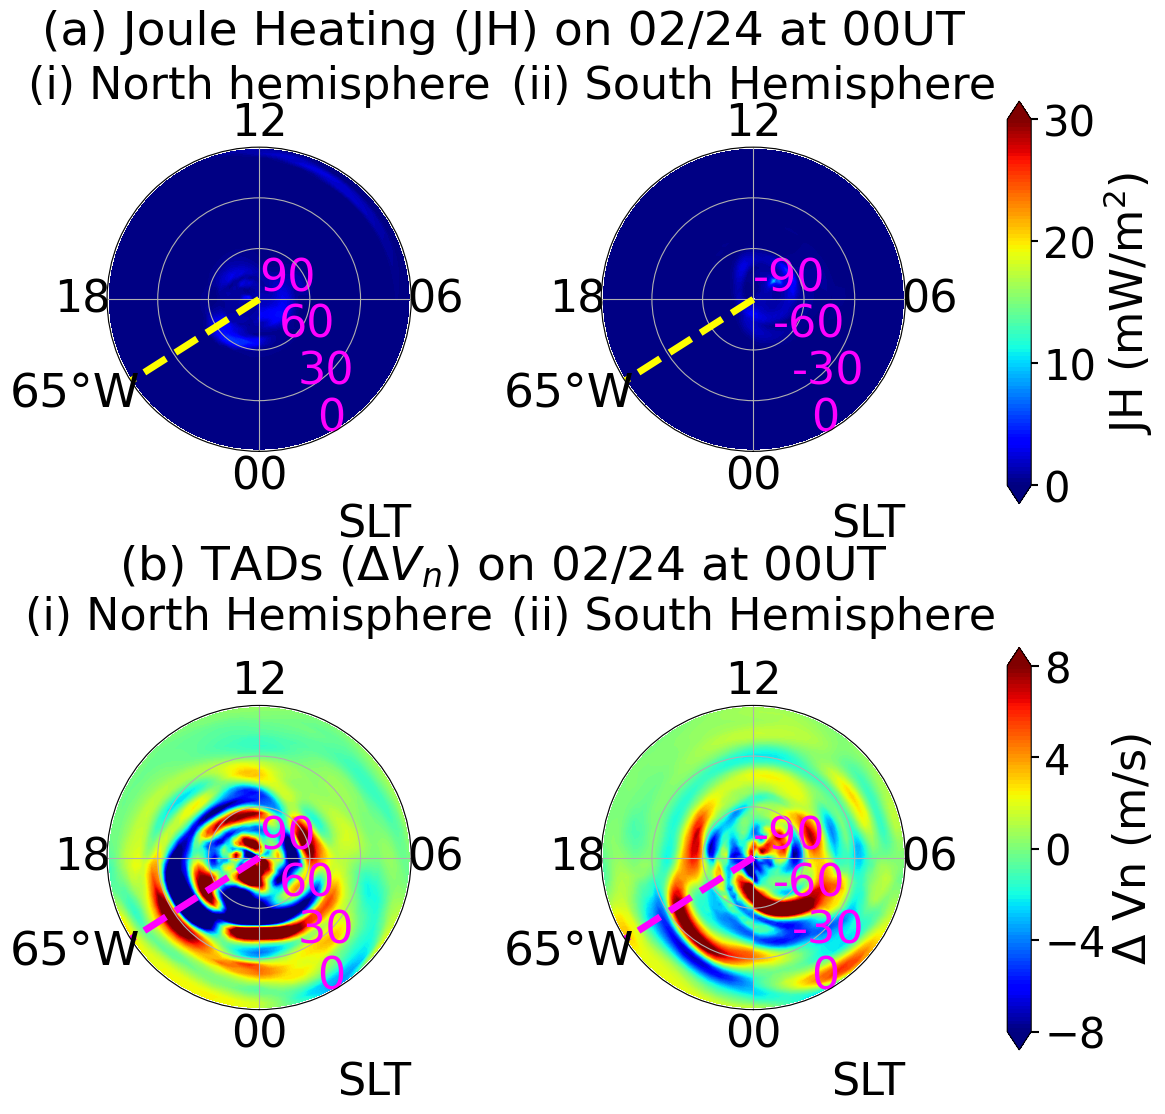

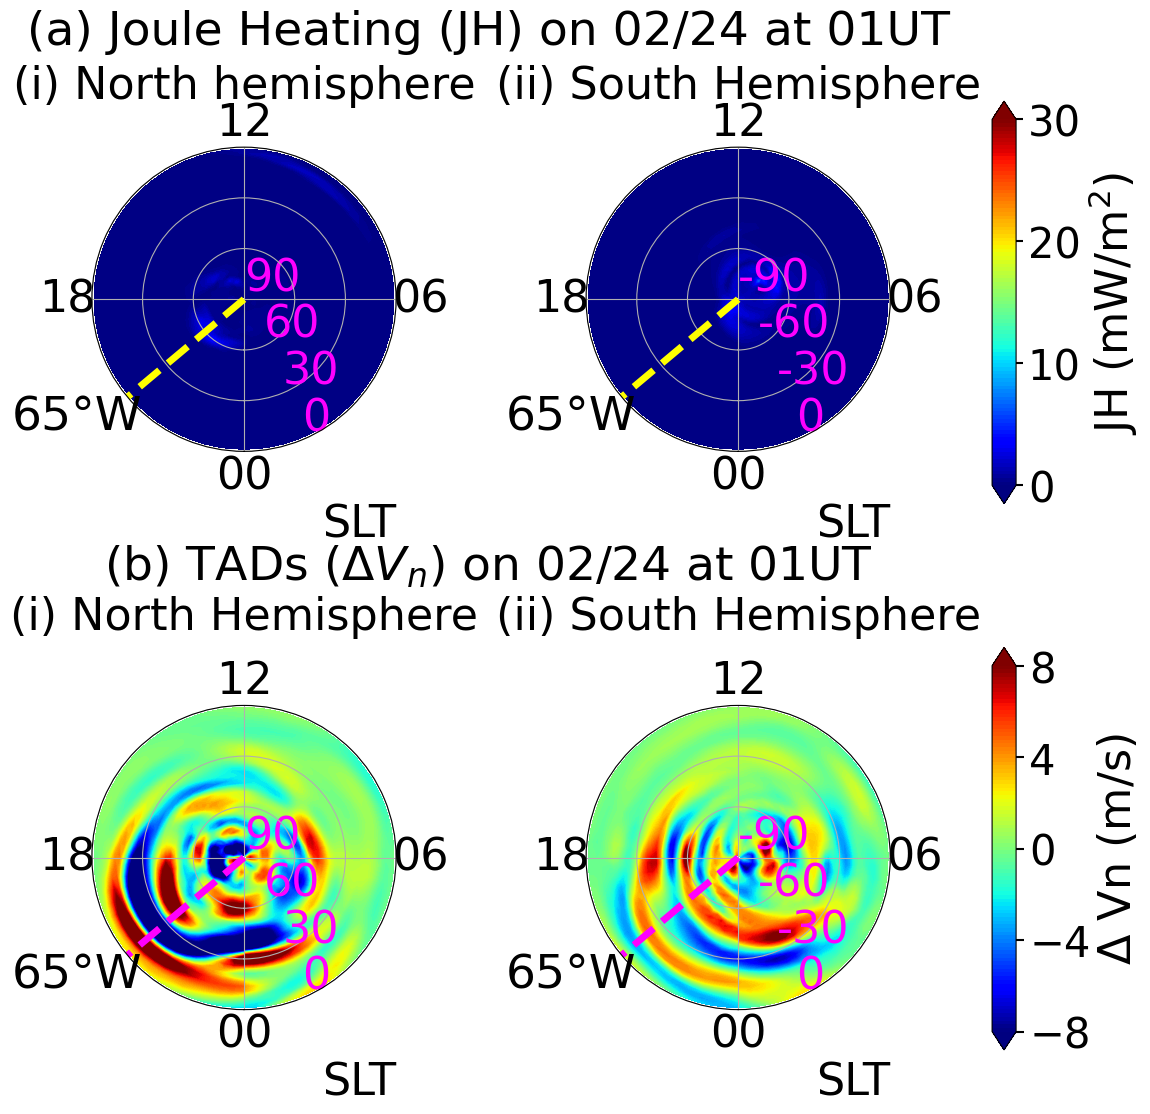

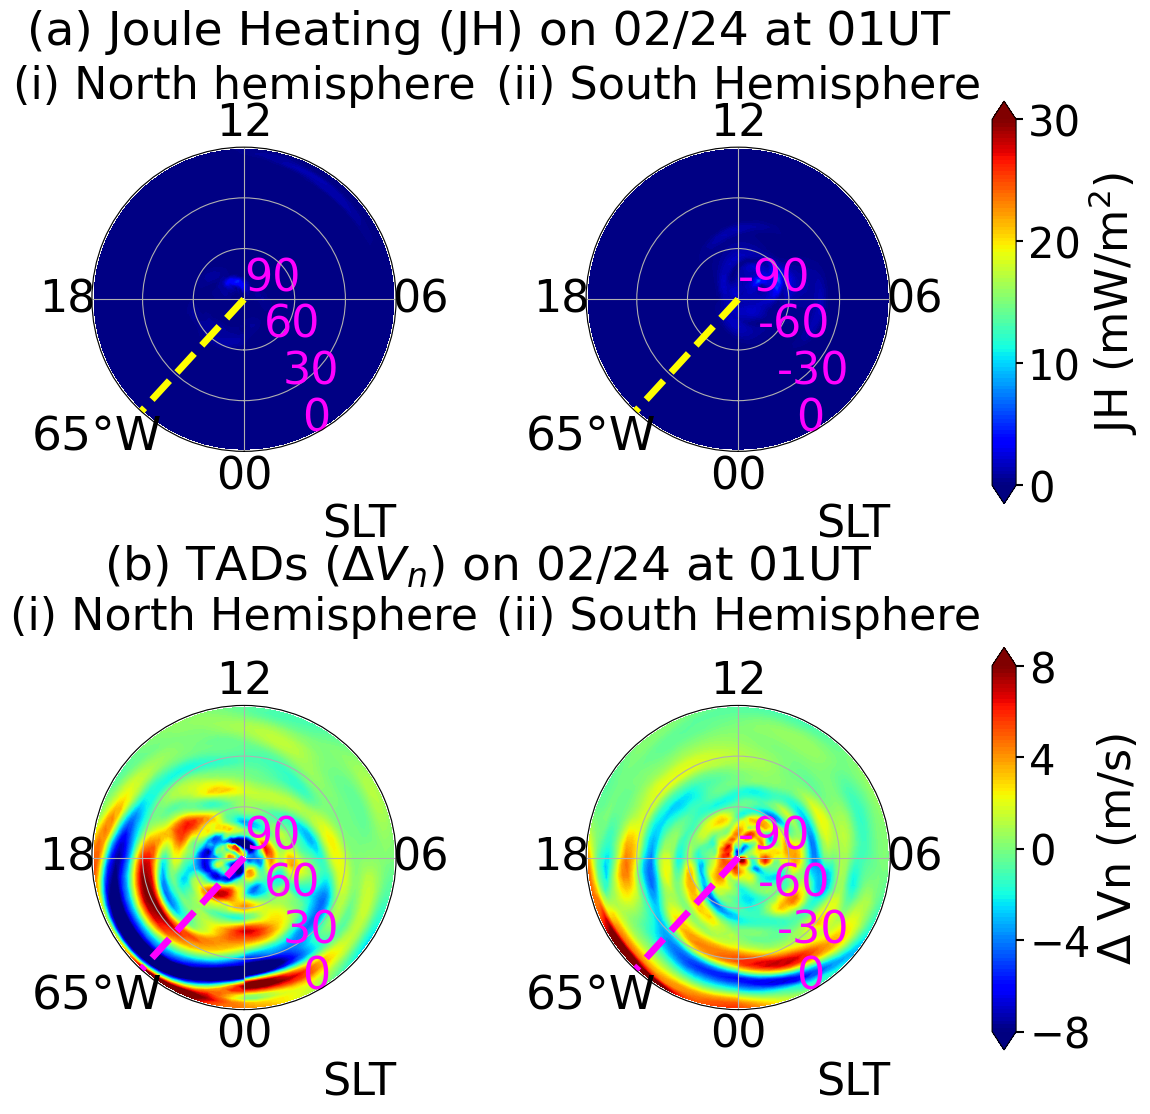

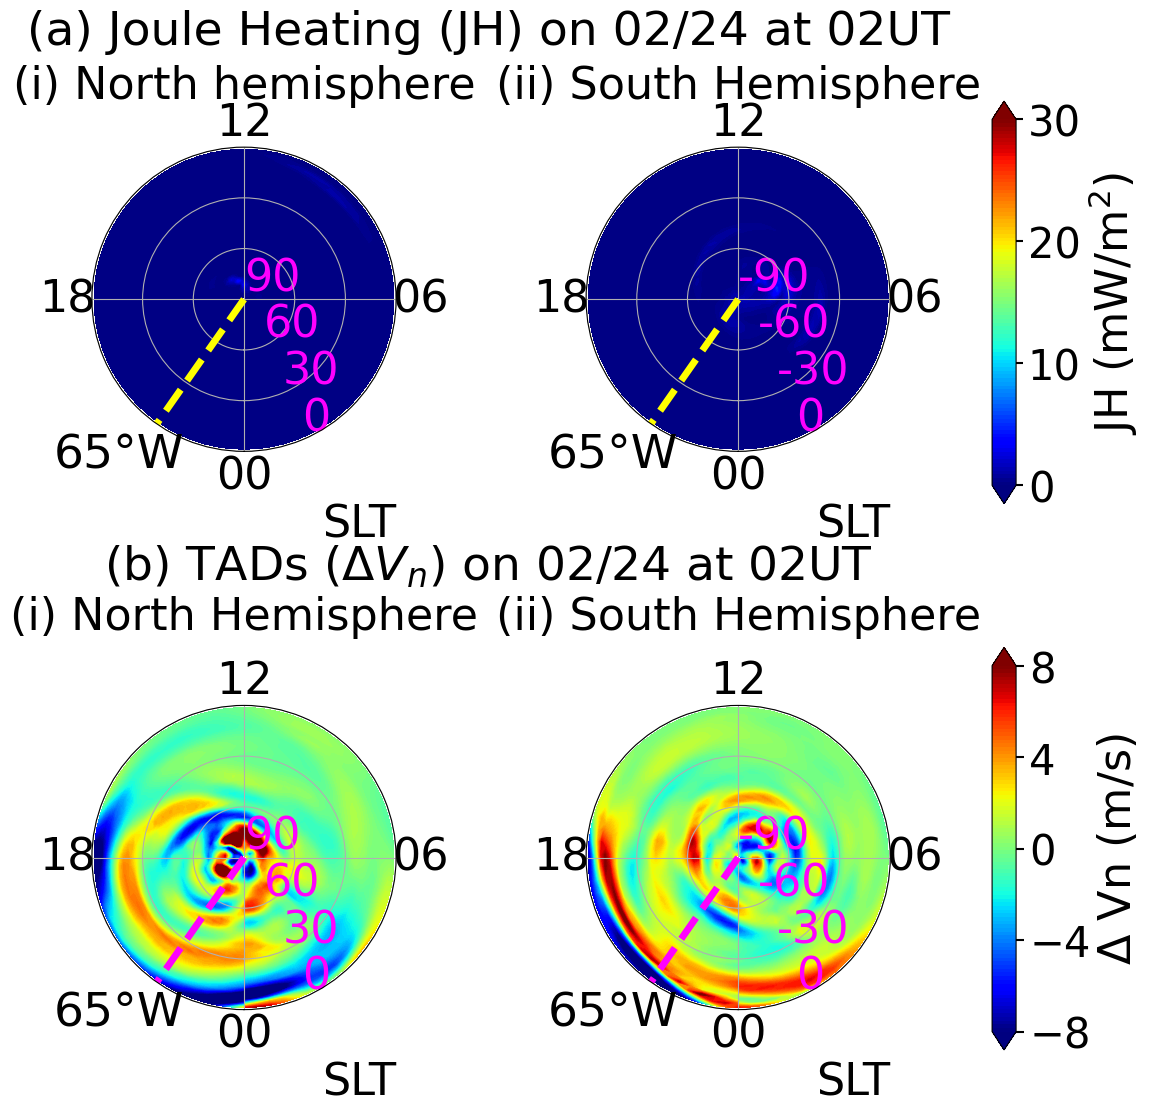

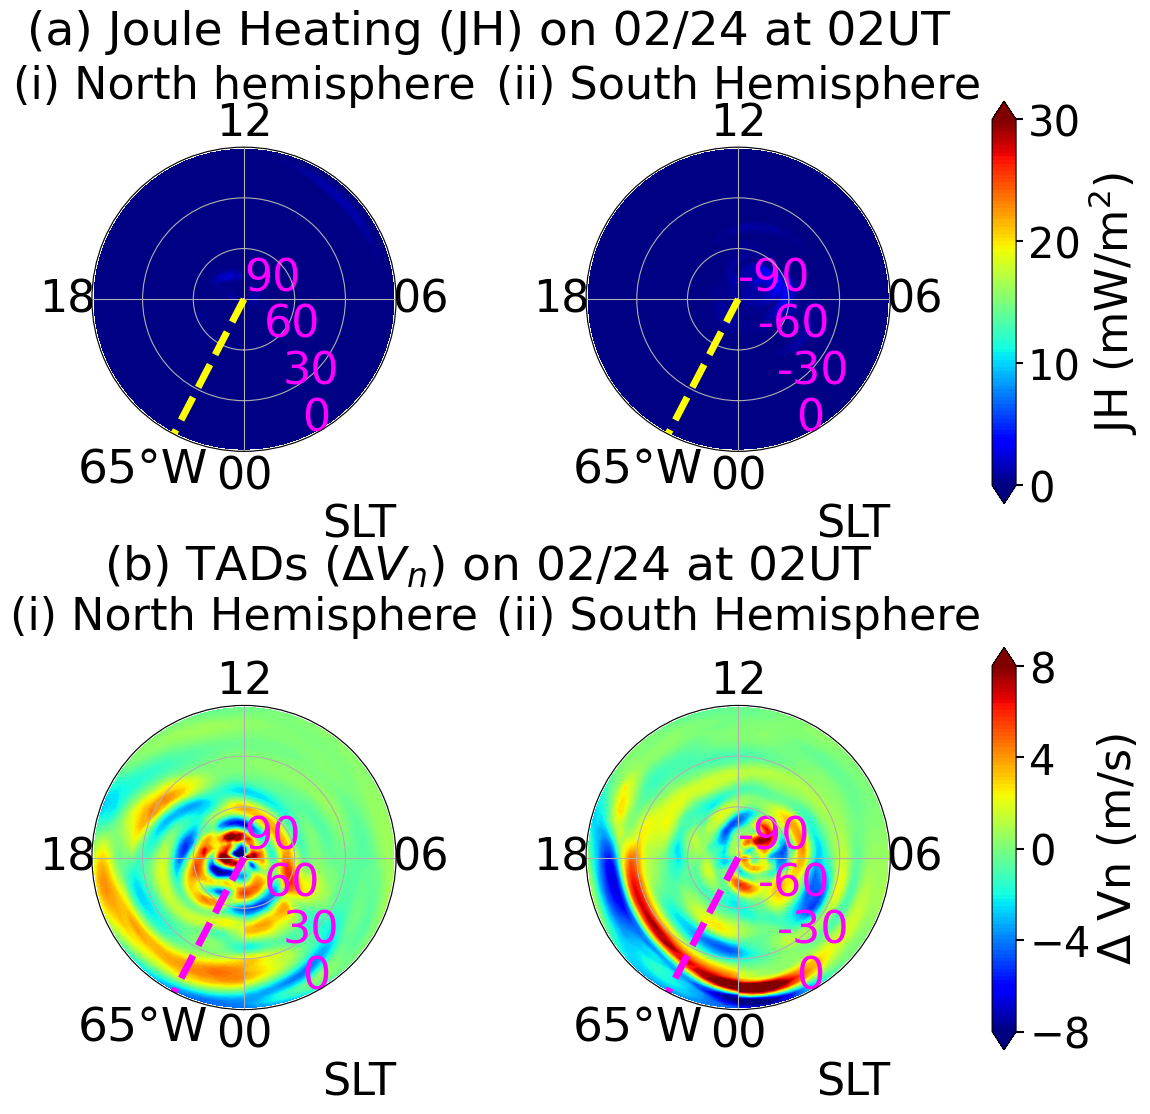

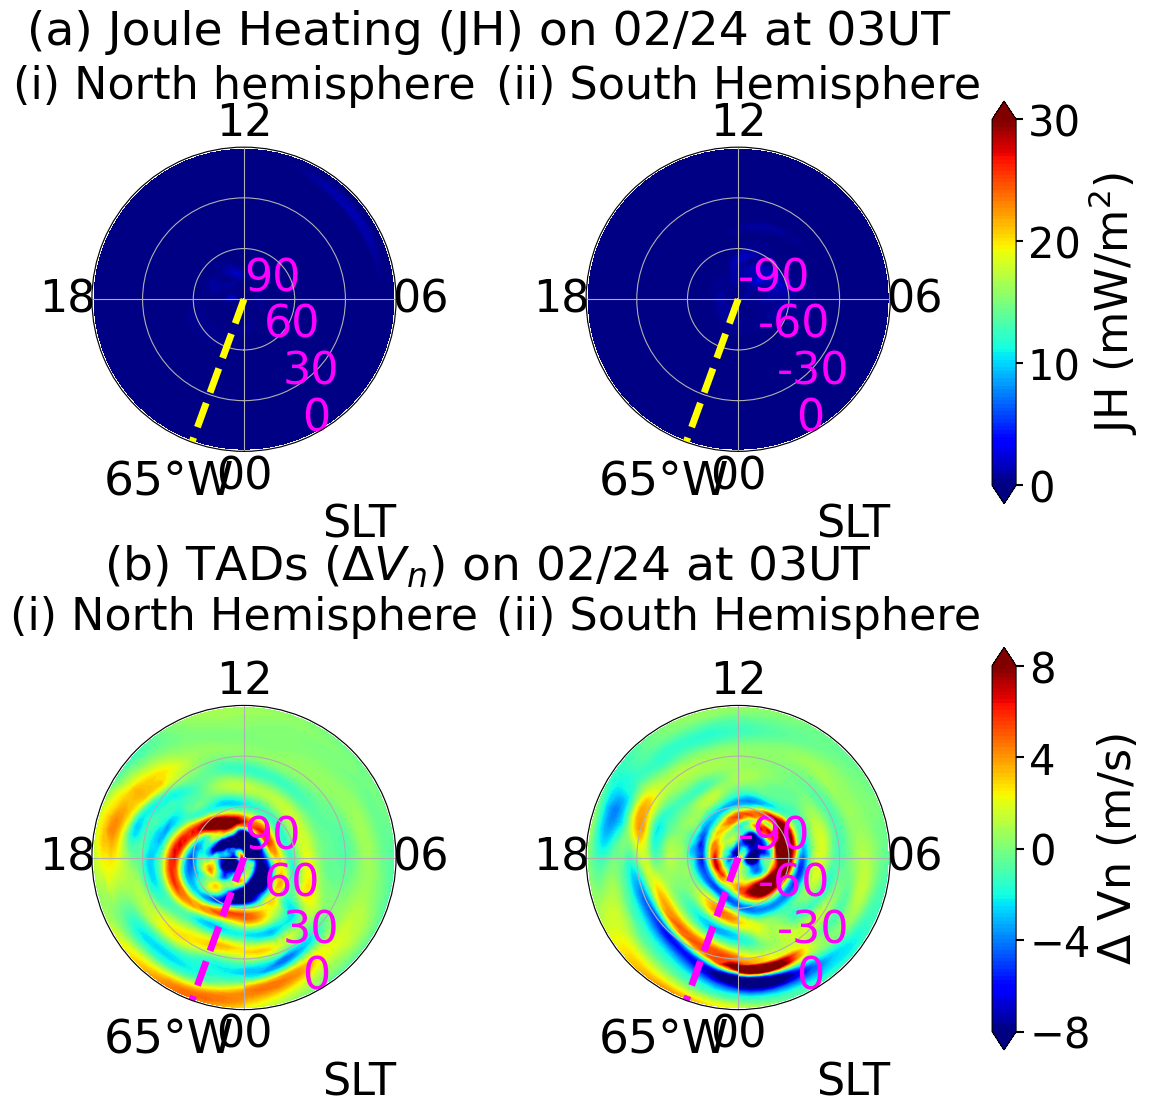

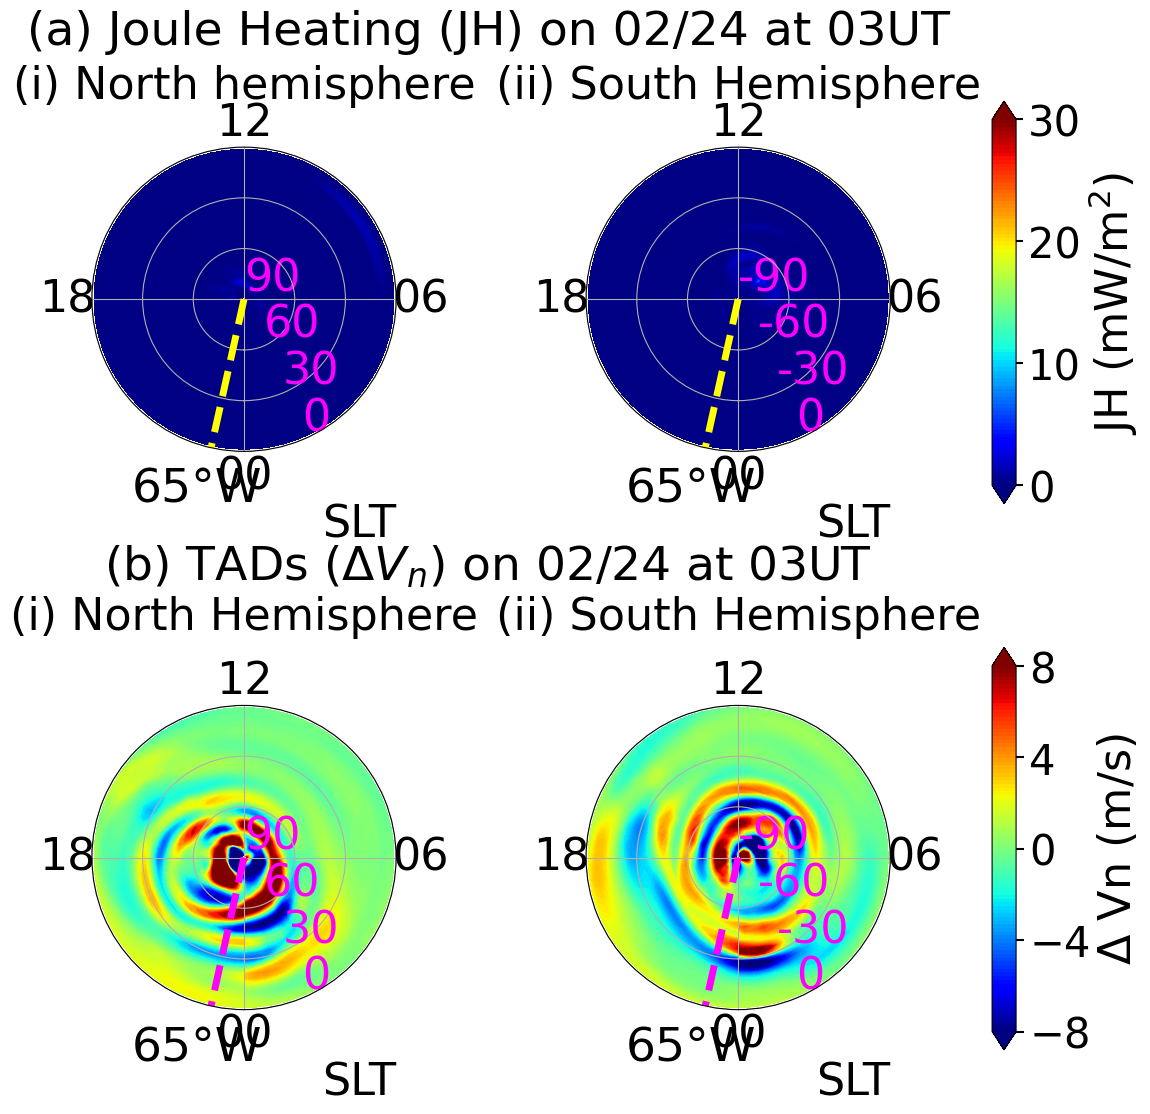

In [151]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Example: extracting variables
int_jh = ds['int_jh']*1000
vn = ds['Vn']
vn_diff = ds['Vn_diff']
glon = ds['glon']
glat = ds['glat']

# Select time index
time_index = 100
start_t = pd.to_datetime('2023-02-24 00:00:00')
time_t = [start_t + i*pd.Timedelta(minutes=30) for i in range(8)]

for t in time_t:
    # Northern Hemisphere: 40° to 90°
    glat_n = glat.where(glat >= 0, drop=True)
    colat_n = 90 - glat_n.values
    Z_n = int_jh.sel(ut=t, method='nearest').sel(glat=glat_n).values.T  # Transpose for (lat, lon)
    vn_n = vn.sel(ut=t, method='nearest').sel(glat=glat_n).values.T
    vn_df_n = vn_diff.sel(ut=t, method='nearest').sel(glat=glat_n).values.T

    # Southern Hemisphere: -40° to -90°
    glat_s = glat.where(glat <= -0, drop=True)
    colat_s = 90 + glat_s.values  # Use + for southern
    Z_s = int_jh.sel(ut=t, method='nearest').sel(glat=glat_s).values.T
    vn_s = vn.sel(ut=t, method='nearest').sel(glat=glat_s).values.T
    vn_df_s = vn_diff.sel(ut=t, method='nearest').sel(glat=glat_s).values.T

    # Compute SLT corresponding to 65°W at current time
    ut_hours = t.hour + t.minute / 60  # UT in hours
    lon_deg = -65                      # 65°W
    slt = (ut_hours + lon_deg / 15) % 24  # SLT in hours (0–24)
    theta_rad = np.deg2rad(15 * slt)      # Convert SLT (0–24h) to angle (0–360° → radians)

    #print(max(Z_n), max(Z_s))

    # SLT angle (0 to 360 deg -> radians)
    theta = np.linspace(0, 2 * np.pi, len(glon))

    # Meshgrids
    Theta_n, R_n = np.meshgrid(theta, colat_n)
    Theta_s, R_s = np.meshgrid(theta, colat_s)

    # Plot
    fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 11.5))


    # Shared settings
    def format_polar(ax, radial_array, hemisphere='north'):
        ax.set_theta_zero_location("S")
        ax.set_theta_direction(1)
        ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
        ax.set_xticklabels(['00', '06', '12', '18'])

        # Define desired latitude circles
        latitudes = np.arange(90, -1, -30) # 90 to 0
        #latitudes = np.arange(90, 39, -10)  # 90 to 40
        if hemisphere == 'north':
            r_ticks = 90 - latitudes  # colatitudes
            labels = [str(lat) for lat in latitudes]
        else:
            r_ticks = 90 + latitudes * -1  # colatitudes from negative lat
            labels = [str(lat) for lat in latitudes * -1]

        ax.set_ylim(min(r_ticks), max(r_ticks))
        ax.set_yticks(r_ticks)
        ax.set_yticklabels(labels)
        ax.tick_params(axis='y', labelsize=32,colors='magenta')
        ax.tick_params(axis='x', labelsize=32, pad=7)
        

    # Left: North Pole
    c1 = axs[0,0].contourf(Theta_n, R_n, Z_n, levels=np.linspace(0, 30, 100), cmap='jet',extend='both')
    '''
    c1 = axs[0,0].contourf(
        Theta_n, R_n, Z_n,
        levels=np.logspace(0.01, np.log10(np.max(Z_n)), 100),
        norm=LogNorm(vmin=0.01, vmax=np.max(Z_n)),
        cmap='jet', extend='both'
    )
    '''
    c3 = axs[1,0].contourf(Theta_n, R_n, vn_df_n, levels=np.linspace(-8,8,100), cmap='jet', extend='both')
    format_polar(axs[0,0], colat_n, hemisphere='north')
    format_polar(axs[1,0], colat_n, hemisphere='north')
    axs[0,0].set_title("(i) North hemisphere", pad=35,fontsize=32)
    axs[1,0].set_title("(i) North Hemisphere", pad=55,fontsize=32)
    
    # Right: South Pole
    c2 = axs[0,1].contourf(Theta_s, R_s, Z_s, levels=np.linspace(0, 30, 100), cmap='jet',extend='both')
    '''
    c2 = axs[0,1].contourf(
        Theta_s, R_s, Z_s,
        levels=np.logspace(0.01, np.log10(np.max(Z_s)), 100),
        norm=LogNorm(vmin=0.01, vmax=np.max(Z_s)),
        cmap='jet', extend='both'
    )
    '''
    c4 = axs[1,1].contourf(Theta_s, R_s, vn_df_s, levels=np.linspace(-8,8,100), cmap='jet',extend='both')
    format_polar(axs[0,1], colat_s, hemisphere='south')
    format_polar(axs[1,1], colat_s, hemisphere='south')
    axs[0,1].set_title("(ii) South Hemisphere", pad=35,fontsize=32)
    axs[1,1].set_title("(ii) South Hemisphere", pad=55,fontsize=32)
    
    # Shared Colorbar
    fig.subplots_adjust(right=0.88, hspace=0.22)
    # First colorbar
    cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.35])
    cb1 = fig.colorbar(c1, cax=cbar_ax1)
    cb1.set_ticks([0, 10, 20, 30])
    #cb1 = fig.colorbar(c1, cax=cbar_ax1, ticks=[0.00001, 0.0001, 0.001, 0.01, 0.1, 10])
    #print(min(Z_s), max(Z_s))
    cb1.set_label(r'JH (mW/m$^2$)', fontsize=32)         # Label font size
    cb1.ax.tick_params(labelsize=30, length=5, width=1.5)           # Tick label size & tick size
    # Second colorbar
    cbar_ax2 = fig.add_axes([0.92, 0.075, 0.02, 0.35])
    cb2 = fig.colorbar(c3, cax=cbar_ax2)
    cb2.set_ticks([-8, -4, 0, 4, 8])
    cb2.set_label(r'$\Delta$ Vn (m/s)', fontsize=32)
    cb2.ax.tick_params(labelsize=30, length=6, width=1.5)

    # Plot SLT line corresponding to 65°W
    for i in range(2):
        for j in range(2):
            ax = axs[i, j]
            r_max = ax.get_ylim()[1]
            color_j = ['yellow', 'magenta']
            ax.plot([theta_rad, theta_rad], [0, r_max], color=color_j[i], linestyle='--', linewidth=5)
            ax.text(theta_rad, r_max + 39, '65°W', ha='center', va='bottom', fontsize=34, color='black')
            ax.set_xlabel('SLT', fontsize=32,loc='right')
            
    # Optional label
    '''
    axs[0,0].text(-0.12, 0.5, '(a) Joule Heating', color='magenta', fontsize=18,
                rotation='vertical', transform=axs[0,0].transAxes, ha='center', va='center')
    axs[1,0].text(-0.12, 0.5, r'(b) $\Delta$ Meridional Wind', color='magenta', fontsize=18,
                rotation='vertical', transform=axs[1,0].transAxes, ha='center', va='center')
    '''
    #fig.suptitle('(a) Joule Heating (JH) on 02/24 at 00UT', fontsize=34)
    fig.suptitle(f'(a) Joule Heating (JH) on 02/24 at {str(t)[-8:-6]}UT',fontsize=34)
    fig.subplots_adjust(top=0.86)
    
    #fig.text(0.5, 0.475, fr'(b) TADs ($\Delta$$V_n$) on 02/24 at 01UT', ha='center', va='bottom', fontsize=34)
    fig.text(0.5, 0.475, fr'(b) TADs ($\Delta$$V_n$) on 02/24 at {str(t + pd.Timedelta(hours=0))[-8:-6]}UT', ha='center', va='bottom', fontsize=34)
    fig.subplots_adjust(hspace=0.835)

    #plt.tight_layout()
    plt.show()


In [152]:
print(ds)

<xarray.Dataset> Size: 233MB
Dimensions:   (ut: 433, glon: 72, glat: 72)
Coordinates:
  * ut        (ut) datetime64[ns] 3kB 2023-02-22 ... 2023-02-24T23:59:58
  * glon      (glon) float64 576B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * glat      (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables: (12/13)
    pot       (ut, glon, glat) float64 18MB -1.886e+04 -1.402e+04 ... -103.3
    tec       (ut, glon, glat) float64 18MB 13.77 13.73 13.41 ... 2.218 3.505
    int_jh    (ut, glon, glat) float64 18MB 6.246e-05 8.08e-05 ... 1.558e-05
    eflux     (ut, glon, glat) float64 18MB 0.09431 0.1586 ... 0.02976 0.04101
    ExB       (ut, glon, glat) float64 18MB -42.36 -65.72 -80.8 ... 1.24 0.7951
    ON2       (ut, glon, glat) float64 18MB 0.3514 0.3704 0.3879 ... 0.591 0.564
    ...        ...
    Rho       (ut, glon, glat) float64 18MB 5.434e-12 5.255e-12 ... 3.006e-12
    Vn        (ut, glon, glat) float64 18MB 138.9 125.2 102.5 ... -279.1 -279.8
    Vn_avg 

<xarray.Dataset> Size: 278kB
Dimensions:   (ut: 37, glat: 72)
Coordinates:
  * ut        (ut) datetime64[ns] 296B 2023-02-23T22:59:59 ... 2023-02-24T05:...
    glon      float64 8B 297.5
  * glat      (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables: (12/13)
    pot       (ut, glat) float64 21kB -1.602e+04 -1.38e+04 ... -1.082e+04
    tec       (ut, glat) float64 21kB 8.923 8.994 9.421 ... 2.214 2.718 4.774
    int_jh    (ut, glat) float64 21kB 0.001404 0.001486 ... 0.0001085 6.194e-05
    eflux     (ut, glat) float64 21kB 0.2557 0.3897 0.3428 ... 0.00954 0.02695
    ExB       (ut, glat) float64 21kB -77.74 -44.04 7.865 ... 14.89 6.01 2.331
    ON2       (ut, glat) float64 21kB 0.2592 0.2712 0.2949 ... 0.4538 0.4469
    ...        ...
    Rho       (ut, glat) float64 21kB 5.405e-12 5.417e-12 ... 4.21e-12 4.238e-12
    Vn        (ut, glat) float64 21kB 62.4 39.67 28.0 ... -272.9 -273.9 -264.8
    Vn_avg    (ut, glat) float64 21kB 68.68 46.13 27.41 ... -272.6

<Figure size 1200x1600 with 0 Axes>

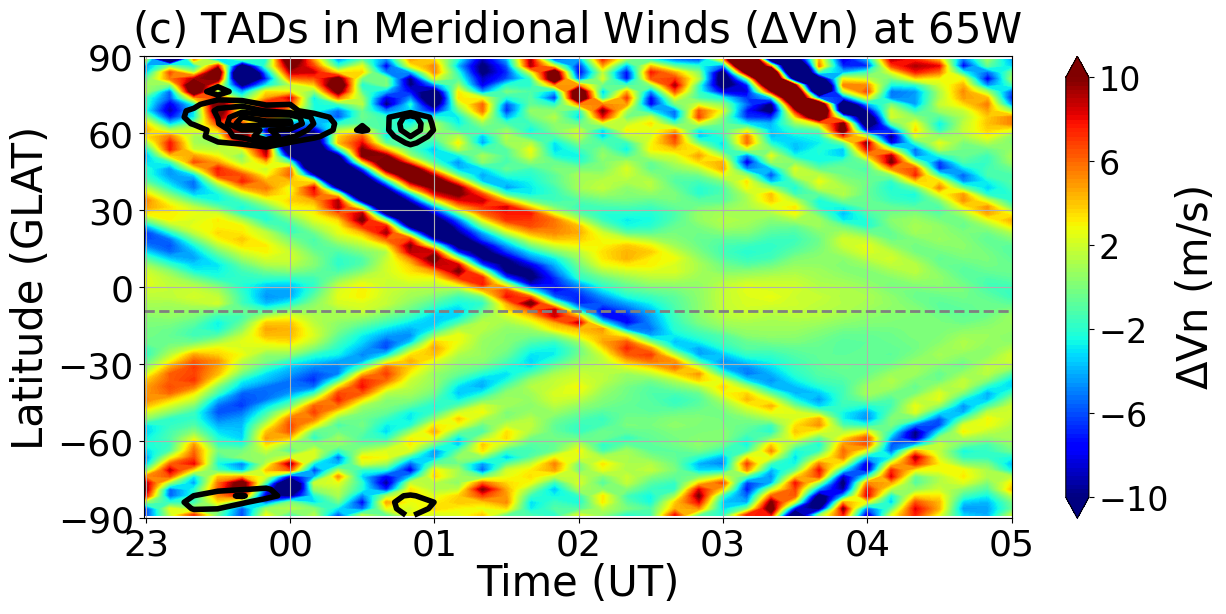

In [163]:
fig=plt.figure(figsize=(12,16))
specs=fig.add_gridspec(4,4,width_ratios=[1,1,1,0.1],height_ratios=[1,1,1,1], wspace=0.37)

time_s = pd.to_datetime('2023-02-23 22:59:00')
time_e = pd.to_datetime('2023-02-24 05:00:00')
ds_sub = ds.sel(ut=slice(time_s,time_e))
ds_sub = ds_sub.sel(glon=360-65, method='nearest')
print(ds_sub)
ut = ds_sub.ut.values
lats = ds_sub.glat.values
vn_diff = ds_sub.Vn_diff.values.T
vtec = ds_sub.tec_diff.values.T
jh = ds_sub.int_jh.values.T

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
level1 = np.linspace(-10,10,100)  # Adjust levels as needed
p1 = ax.contourf(ut, lats, vn_diff, cmap='jet',levels=level1,extend='both')
cbar1 = fig.colorbar(p1, ax=ax)
cbar1.set_label(fr'$\Delta$Vn (m/s)', fontsize=30)
cbar1.set_ticks([-10, -6, -2, 2, 6, 10])
cbar1.ax.tick_params(labelsize=24)
ax.axhline(y=-9.13, color='gray', linestyle='--',linewidth=2)
ax.set_xlim(time_s,time_e)
ax.set_title(fr'(c) TADs in Meridional Winds ($\Delta$Vn) at 65W',fontsize=30,pad=10)
ax.set_xlabel('Time (UT)',fontsize=30,labelpad=0)
ax.set_ylabel('Latitude (GLAT)',fontsize=30)
ax.set_yticks(np.arange(-90, 91, 30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.tick_params(axis='both',labelsize=26)
    
ax.set_ylim(-90,90)
ax.grid()


level_jh = np.linspace(0, 30*10**-3, 10)  # Adjust number of contours
contour_lines = ax.contour(ut, lats, jh, levels=level_jh, colors='black', linewidths=4)
#ax.clabel(contour_lines, fmt='%.2e', fontsize=8)

In [76]:
# Define the time window
start_time = np.datetime64("2023-02-23T23:00:00")
end_time = np.datetime64("2023-02-24T04:00:00")

# Subset the dataset
ds_sub = ds.sel(ut=slice(start_time, end_time))

# Extract relevant variables
vn_diff = ds_sub['Vn_diff']
#ut_sub = ds_sub['ut'].values
glon = ds['glon']
glat = ds['glat']
ut = ds_sub['ut'].values

# Get meshgrid of lon and time
UT_hours = np.array([pd.Timestamp(t).hour + pd.Timestamp(t).minute / 60 for t in ut])
glon_vals = glon.values

# Init empty arrays to collect keogram data
keogram_nh = []
keogram_sh = []

# Loop over time steps
for t_idx, t in enumerate(ut_sub):
    ut_hour = UT_hours[t_idx]
    
    # Convert SLT window to longitude range
    lon_nh_min = 15 * (slt_window_nh[0] - ut_hour)
    lon_nh_max = 15 * (slt_window_nh[1] - ut_hour)
    
    lon_sh_min = 15 * (slt_window_sh[0] - ut_hour)
    lon_sh_max = 15 * (slt_window_sh[1] - ut_hour)
    
    # Normalize to 0–360
    lon_nh_range = ((glon_vals >= lon_nh_min % 360) & (glon_vals <= lon_nh_max % 360))
    lon_sh_range = ((glon_vals >= lon_sh_min % 360) & (glon_vals <= lon_sh_max % 360))
    
    # Extract slices
    vn_slice = vn_diff.isel(ut=t_idx)

    # NH: glat > 0
    nh_vals = vn_slice.where(ds['glat'] > 0, drop=True)
    nh_avg = nh_vals.sel(glon=glon.where(lon_nh_range, drop=True)).mean(dim='glon')
    
    # SH: glat < 0
    sh_vals = vn_slice.where(ds['glat'] < 0, drop=True)
    sh_avg = sh_vals.sel(glon=glon.where(lon_sh_range, drop=True)).mean(dim='glon')
    
    keogram_nh.append(nh_avg.values)
    keogram_sh.append(sh_avg.values)

# Convert to arrays
keogram_nh = np.array(keogram_nh).T  # shape (lat, time)
keogram_sh = np.array(keogram_sh).T

# Get latitudes
glat_nh = ds['glat'].where(ds['glat'] > 0, drop=True).values
glat_sh = ds['glat'].where(ds['glat'] < 0, drop=True).values

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

im1 = axs[0].pcolormesh(UT_hours, glat_nh, keogram_nh, cmap='RdBu_r', shading='auto', vmin=-600, vmax=600)
axs[0].set_title('(a) NH 6–18 SLT', fontsize=14, color='blue')
axs[0].set_ylabel('Geographic Latitude (deg)')
axs[0].set_xlabel('Universal Time (Hours)')
axs[0].text(6, 85, 'LT=6', color='magenta')
axs[0].text(18, 85, 'LT=18', color='magenta')

im2 = axs[1].pcolormesh(UT_hours, glat_sh, keogram_sh, cmap='RdBu_r', shading='auto', vmin=-600, vmax=600)
axs[1].set_title('(b) SH 3–15 SLT', fontsize=14, color='blue')
axs[1].set_xlabel('Universal Time (Hours)')
axs[1].text(3, -85, 'LT=3', color='magenta')
axs[1].text(15, -85, 'LT=15', color='magenta')

# Colorbar
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.8, label='Vn (m/s)')

plt.tight_layout()
plt.show()


NameError: name 'ut_sub' is not defined

[[8.10859821 7.61422754 7.57975646 7.56267142]
 [8.70327482 8.58206456 8.62502058 8.5211827 ]
 [8.90252714 9.02907961 9.09607247 8.91050862]]
[[-88.75 -86.25 -83.75 -81.25]
 [-88.75 -86.25 -83.75 -81.25]
 [-88.75 -86.25 -83.75 -81.25]]
[['2023-02-22T00:00:00.000000000' '2023-02-22T00:00:00.000000000'
  '2023-02-22T00:00:00.000000000' '2023-02-22T00:00:00.000000000']
 ['2023-02-22T00:09:57.000000000' '2023-02-22T00:09:57.000000000'
  '2023-02-22T00:09:57.000000000' '2023-02-22T00:09:57.000000000']
 ['2023-02-22T00:19:57.000000000' '2023-02-22T00:19:57.000000000'
  '2023-02-22T00:19:57.000000000' '2023-02-22T00:19:57.000000000']]
new
[['2023-02-22T00:00:00.000000000' '2023-02-22T00:09:57.000000000'
  '2023-02-22T00:19:57.000000000']
 ['2023-02-22T00:00:00.000000000' '2023-02-22T00:09:57.000000000'
  '2023-02-22T00:19:57.000000000']
 ['2023-02-22T00:00:00.000000000' '2023-02-22T00:09:57.000000000'
  '2023-02-22T00:19:57.000000000']
 ['2023-02-22T00:00:00.000000000' '2023-02-22T00:09:57.00

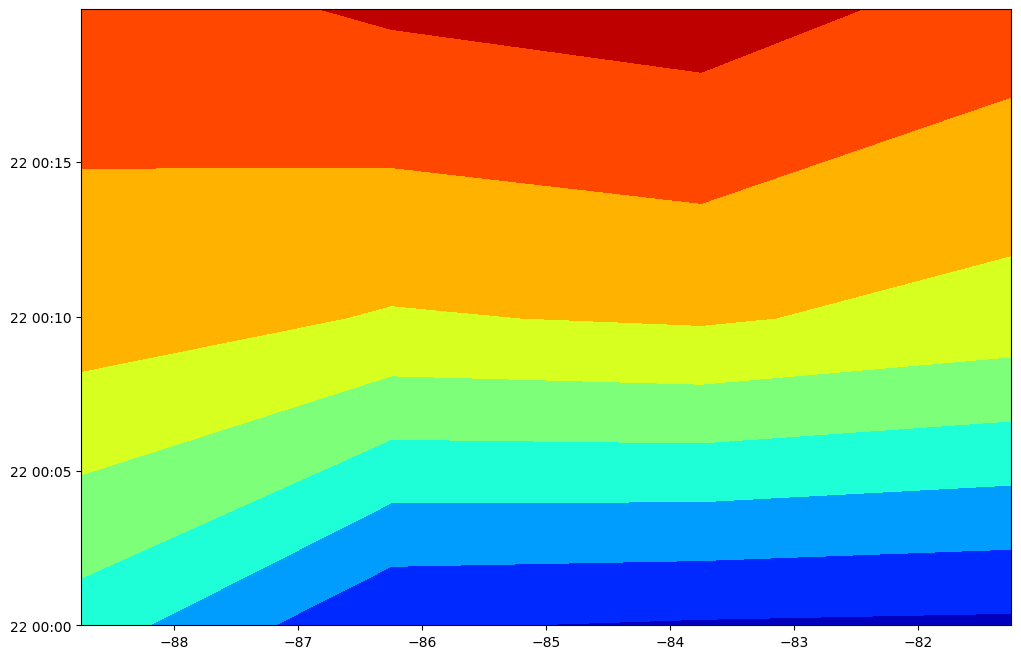

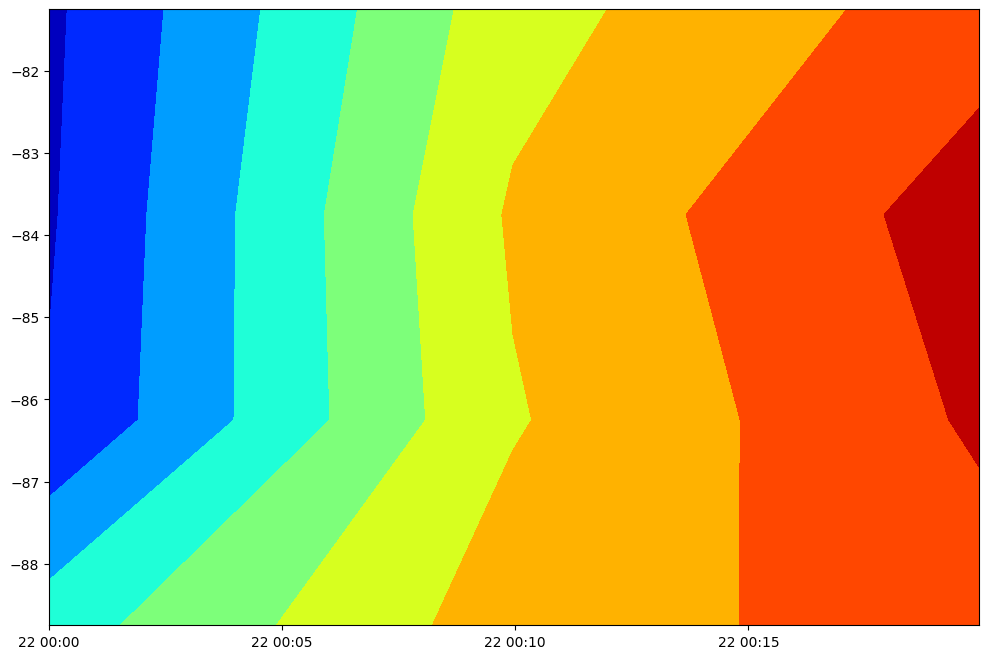

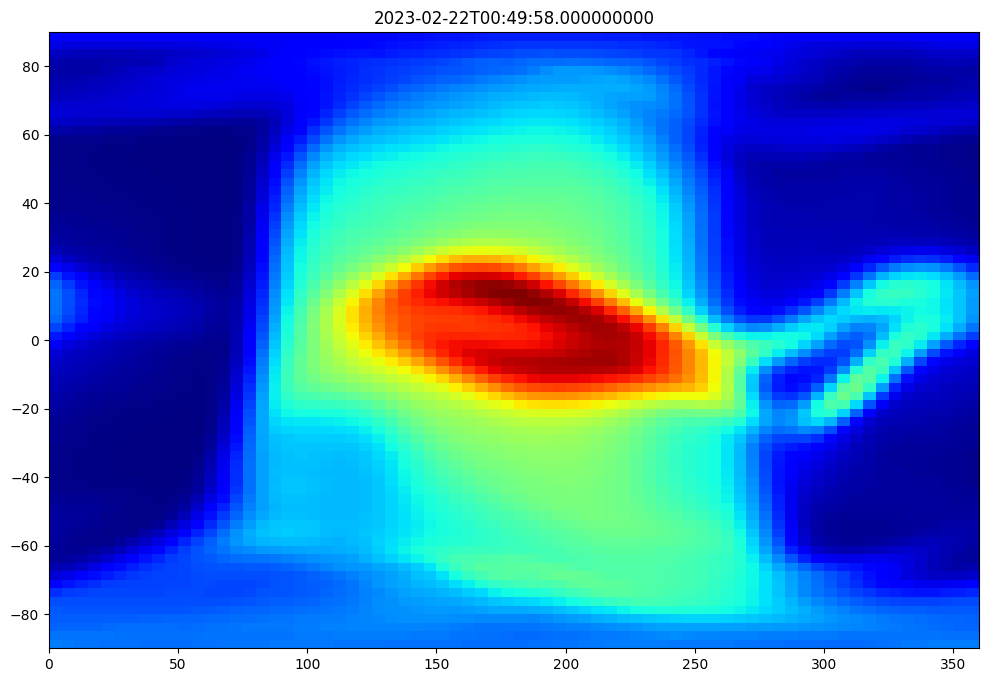

In [77]:
ds1 = ds.sel(glon=75,method='nearest')
ds1 = ds1.isel(ut=[0,1,2], glat=[0,1,2,3])
print(ds1.tec.values)


X, Y = np.meshgrid(ds1.glat.values,ds1.ut.values)
print(X)
print(Y)

plt.figure(figsize=(12,8))
plt.contourf(X, Y, ds1.tec, cmap='jet')

print('new')

Xn, Yn = np.meshgrid(ds1.ut.values, ds1.glat.values)
print(Xn)
print(Yn)
Zn = (ds1.tec.values).T
print(Zn)

plt.figure(figsize=(12,8))
plt.contourf(Xn,Yn,Zn, cmap='jet')
plt.show()



glatn = ds.glat.values
glonn = ds.glon.values
Xt, Yt = np.meshgrid(glonn, glatn)
t = 5
dst = ds.isel(ut=t)
Zt = (dst.tec.values).T

plt.figure(figsize=(12,8))
plt.pcolormesh(Xt,Yt,Zt,cmap='jet')
plt.title(str(ds.ut.values[t]))
plt.show()


In [ ]:

n = 9

for i in range(n):
    x = 2 + (10-2)*i/(n-1)
    print(x)
    


'''
  !!! Vertical first
  iStart = 1
  hgtpos = -1
  do k=1,nhgt_fix
     do i=iStart, nhgt_new-1

        if (hgt_fix(k)/1000.0 .ge. hgt_ext(i) .and. &
             hgt_fix(k)/1000.0 .lt. hgt_ext(i+1)) then
           frik=(hgt_fix(k)/1000.0-hgt_ext(i))/&
                (hgt_ext(i+1)-hgt_ext(i))
           wgt_hgt(1,k)=1.-frik
           wgt_hgt(2,k)=frik
           hgtpos(k)=i
           iStart = i
           exit
        endif
     enddo
'''

2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


Data keys in zpf file: ['ut', 'glon', 'glat', 'pot', 'tec', 'int_jh', 'eflux', 'ExB', 'ON2', 'Wi', 'Rho', 'Vn']
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00
2011-04-19 00:00:00


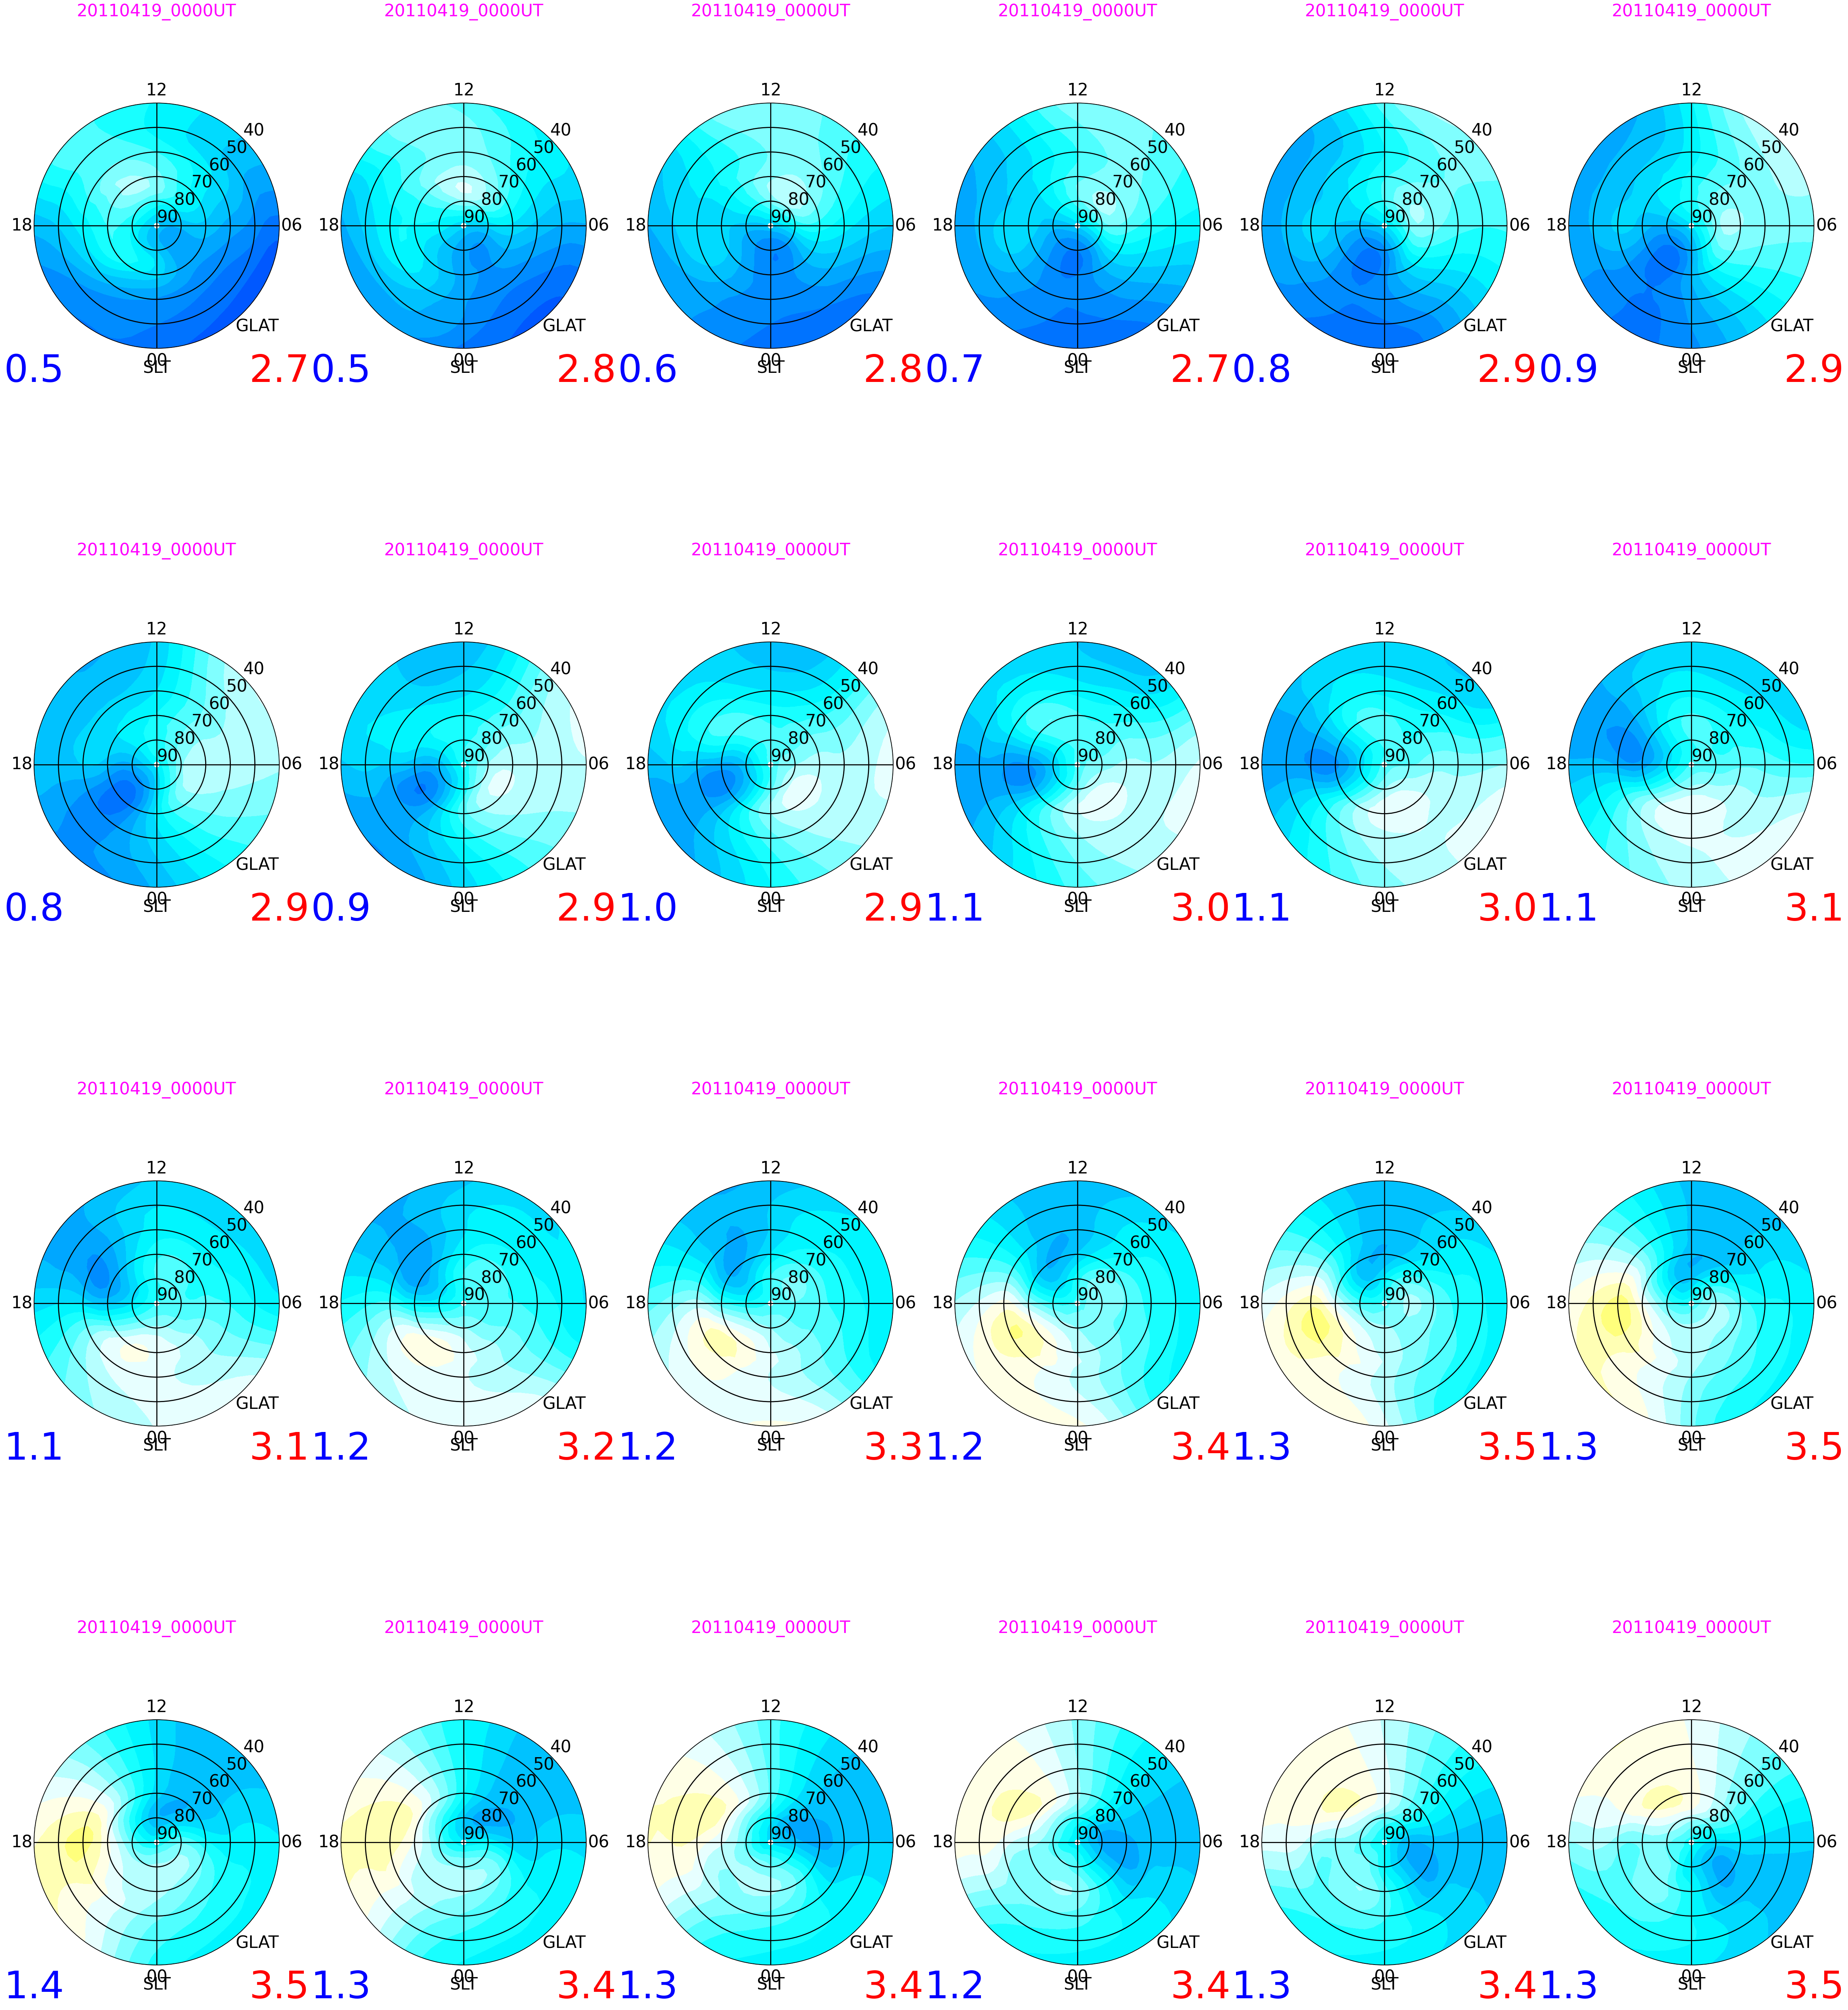

In [ ]:

import sys                                                                      
sys.path.append('/glade/work/prasoonv/gitm/library_ext/libpy') # Change it  

import numpy as np                                                              
import os                                                                       
from glob import glob                                                           
import datetime as dt  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

from set_polar_plots import set_polar_plot, add_axvcolorbar1                                    
from cmap_mylib import make_mid                                                 
                                                                                
from gitm_parms import gitm_contourf, gitm_contour  
from set_figs import add_str 



time_ref=dt.datetime(2012,3,21) 


path = '/glade/work/prasoonv/gitm/'
output_type = '2dall' # '2dall' or '3dall'
by_nature = ['by_neg_10/', 'by_pos_10/']
precip = ['no_precip/', 'e_precip/']
by = by_nature[0]
prec = precip[1]

data_fn = ''
if output_type == '2dall':
    data_pt = path + f'code/2dall/20120318/ashley/{by}output/2dall_final/{prec}'
    data_fn = data_pt + 'combined_parms_2dall.npz'

if output_type == '3dall':
    data_pt = path + f'3DYNAMO/3dall/20120318/ashley/outputs/{by}3dall_final/'
    data_fn = data_pt + 'combined_parms_3dall_398km.npz'
#data_fn = 'path_to_file' # Change it


data=np.load(data_fn)                                                           
print('Data keys in zpf file:', list(data.keys()))
ut=data['ut']                                                                   
lon=data['glon']                                                                
lat=data['glat']                                                                
rho=data['Rho']*1e12                                                                                   
pot=data['pot']/1000  
int_jh=data['int_jh']*1000

save_pt=data_pt + 'sum_plot/'
if not os.path.exists(save_pt):
    os.makedirs(save_pt)


nut=len(ut)
cmap=make_mid(256)

"""
Change the figure size and parameters in the subplots_adjust
"""
fig,axes=plt.subplots(4,6,figsize=(56,60),subplot_kw={'projection': 'polar'})
plt.subplots_adjust(left=0.08,right=0.92,bottom=0.05,top=0.92,wspace=0.25,hspace=0.5)

for iut in range(nut):

    ut_in = ut[iut]
    #print(ut_in)
    if ut_in<0:
        continue
    
    time1=time_ref+dt.timedelta(seconds=round(ut_in*3600))
    print(time1)
    
    time_str=time1.strftime("%Y%m%d_%H%MUT")
    
    irow = int(iut/6)
    icol = iut - irow * 6
    
    
    
    #%%
    ax = axes[irow,icol]
    
    vmin=0                                                                    
    vmax=6     # Change it                                        
    cs_step=0.2                                                             
    cb_step=2
    
    parm=rho[iut]
    fp=lat>0                                                                    
    pot_max=round(parm[:,fp].max(),1)                                             
    pot_min=round(parm[:,fp].min(),1)                                             
    add_str(str(pot_max),ax,fig,72,'r',4,0,-0.01,'center','center')             
    add_str(str(pot_min),ax,fig,72,'b',1,0,-0.01,'center','center') 
    
    
    ang=lon/180*np.pi                                                           
    r=90-lat
    
    ang,r=np.meshgrid(ang,r)                                                    
    ang=ang.T                                                                   
    r=r.T                                                                       
                                                                                
    ang_offset=ut_in/12*np.pi-np.pi/2
    im=gitm_contourf(ax,parm,vmin,vmax,cs_step,cmap,ang,r,ang_offset)

    # Change the parameters if needed
    set_polar_plot(fig,ax,                                                      
                   50,32,'k','k',                                               
                   time_str,0.04,32,'magenta',                                            
                   32,5,32,8,0) 
    
    
    
save_fn = save_pt+by[:-1]+'.pdf'
#print(save_fn)
#plt.savefig(save_fn) # Change it
plt.show()
#plt.close()
